In [1]:
import pandas as pd
from os import listdir
from os.path import isfile, join
from datetime import datetime
import itertools
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import numpy as np
import pandas as pd

import sys, os

import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.graph_objects as go
#from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics

from tensorflow import keras
from keras import layers

import tensorflow as tf
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, Dense, RNN, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops import math_ops

import time

from tensorflow.random import set_seed

import tensorflow_addons as tfa
from tensorflow_addons.rnn import ESNCell

# ----------------------------

### Extração dos RMSEs de cada modelo e criação de um dataframe com todos os resultados. Execute esta célula apenas se vc ainda não tiver o arquivo "df_resultados_RMSEs.xlsx"

In [ ]:
def Cria_lista_com_resultados(pasta_integrante):

    pastas_resultados = ["Resultados_0,5treino_janela20",
                         "Resultados_0,5treino_janela60",
                         "Resultados_0,5treino_janela100",
                         "Resultados_0,25treino_janela20",
                         "Resultados_0,75treino_janela20"]
    
    dict_pastas_resultados = {'0,5treino': 0.5, '0,25treino': 0.25, '0,75treino': 0.75, 'janela20': 20, 'janela60': 60, 'janela100': 100}
    dict_modelos = {"S": "SimpleRNN", "L": "LSTM", "G": "GRU", "E": "ESN"}
    
    resultados_integrante = []
    
    for pasta_resultados in pastas_resultados:

        prop_treino_teste = dict_pastas_resultados[pasta_resultados.split("_")[1]] ##
        tamanho_janela = dict_pastas_resultados[pasta_resultados.split("_")[2]] ##
        
        path = "Dados/" + pasta_integrante + "/" + pasta_resultados
        arquivos_excel = [f for f in listdir(path) if isfile(join(path, f))]
        
        for arquivo in arquivos_excel:
            modelo_algoritmo = dict_modelos[arquivo.split('_')[1]]  ##
            num_camadas = arquivo.split('_').count(arquivo.split('_')[1])  ##
            num_tot_neuronios = arquivo.split('_')[-2]  ##
            
            resultados = pd.read_excel(path + "/" + arquivo, sheet_name='RMSEs')

            media_RMSE = pd.DataFrame.mean(resultados[['replica 1', 'replica 2', 'replica 3']].iloc[-1,:]) ## A última linha contém a média de cada réplica
            
            desvpad_RMSE = pd.DataFrame.std(resultados[['replica 1', 'replica 2', 'replica 3']].iloc[-1,:]) ##
        
            lista_resultado = [modelo_algoritmo, num_camadas, num_tot_neuronios, prop_treino_teste, tamanho_janela, media_RMSE, desvpad_RMSE]
            resultados_integrante.append(lista_resultado)
            
    #print(resultados_integrante)
            
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)    
            
    return(resultados_integrante)

df1 = Cria_lista_com_resultados('Artur')
df2 = Cria_lista_com_resultados('Felipe')
df3 = Cria_lista_com_resultados('JP')

df_resultados = df1+df2+df3
df_resultados = pd.DataFrame(df_resultados, columns = ['Modelo Algoritmo', 'Número camadas', 'Número total neurônios', 'Proporcao treino teste', 'Tamanho janela', 'RMSE medio', 'Desvio padrao RMSE'])
df_resultados

# ----------------------------

In [2]:
df_resultados = pd.read_excel("df_resultados_RMSEs.xlsx")
df_resultados = df_resultados.drop(columns = 'Unnamed: 0')
df_resultados = df_resultados.rename(columns = {"Modelo Algoritmo": "Modelo", "Número camadas": "Número de camadas", 
                                "Número total neurônios": "Número total de neurônios",
                                "Proporcao treino teste": "Proporção treino/teste",
                                "Tamanho janela": "Tamanho das janelas",
                                "RMSE medio": "RMSE médio",
                                "Desvio padrao RMSE": "Desvio padrão RMSE"})

df_resultados

Modelo  Número de camadas  Número total de neurônios  \
0    SimpleRNN                  3                         48   
1         LSTM                  3                         48   
2          GRU                  3                         48   
3          ESN                  3                         48   
4    SimpleRNN                  2                         48   
..         ...                ...                        ...   
175  SimpleRNN                  2                         60   
176       LSTM                  2                         60   
177        GRU                  2                         60   
178        ESN                  2                         60   
179  SimpleRNN                  1                         60   

     Proporção treino/teste  Tamanho das janelas  RMSE médio  \
0                      0.50                   20    0.963568   
1                      0.50                   20    0.819053   
2                      0.50                   20    0.450891   
3                      0.50                   20    0.777760   
4                      0.50                   20    1.349156   
..                      ...                  ...         ...   
175                    0.75                   20    1.209116   
176                    0.75                   20    1.724059   
177                    0.75                   20    0.414048   
178                    0.75                   20    1.657526   
179                    0.75                   20    1.297936   

     Desvio padrão RMSE  
0              0.483722  
1              0.368387  
2              0.167514  
3              0.286317  
4              0.570979  
..                  ...  
175            0.198667  
176            0.118844  
177            0.087352  
178            1.007652  
179            0.528964  

[180 rows x 7 columns]

### Fixa os valores de 4 colunas (3 delas serão o 'título' do plot, e 1 delas será uma curva, ou seja, uma variável parametrizada), e bota uma quinta coluna no eixo x. O eixo y será sempre RMSE medio. 

In [3]:
combinacoes_cols = []
for i in itertools.combinations([0,1,2,3,4], 3):
    combinacoes_cols.append(i)
combinacoes_cols


cols = df_resultados.columns[:5]
infos_plot = []

for combinacao in combinacoes_cols:
    
    combinacao = np.array(combinacao)
    num_colfixa1 = combinacao[0]
    num_colfixa2 = combinacao[1]
    num_colfixa3 = combinacao[2]
    
    cols_restantes = np.delete(np.array(range(5)),combinacao)
    num_colrestante1 = cols_restantes[0]
    num_colrestante2 = cols_restantes[1]
    
    for i in pd.unique(df_resultados[cols[num_colfixa1]]):
    
        for j in pd.unique(df_resultados[cols[num_colfixa2]]):
    
            for k in pd.unique(df_resultados[cols[num_colfixa3]]):
                
                infos_plot.append([[cols[num_colfixa1], cols[num_colfixa2], cols[num_colfixa3]], 
                                   [i,j,k], 
                                   [cols[num_colrestante1], cols[num_colrestante2]],
                                   [list(pd.unique(df_resultados[cols[num_colrestante1]])), list(pd.unique(df_resultados[cols[num_colrestante2]])) ] ])
                
                infos_plot.append([[cols[num_colfixa1], cols[num_colfixa2], cols[num_colfixa3]], 
                                   [i,j,k], 
                                   [cols[num_colrestante2], cols[num_colrestante1]],
                                   [list(pd.unique(df_resultados[cols[num_colrestante2]])), list(pd.unique(df_resultados[cols[num_colrestante1]])) ]])


In [4]:
print(len(infos_plot))
print(infos_plot[0])

648
[['Modelo', 'Número de camadas', 'Número total de neurônios'], ['SimpleRNN', 3, 48], ['Proporção treino/teste', 'Tamanho das janelas'], [[0.5, 0.25, 0.75], [20, 60, 100]]]


In [5]:
# Combinacoes_interessantes refere-se ao conjunto de resultados que consistem de RMSEs estritamente crescentes ou decrescentes.
combinacoes_interessantes = []

for info in infos_plot:
    filtro1 = df_resultados[info[0][0]] == info[1][0]
    filtro2 = df_resultados[info[0][1]] == info[1][1]
    filtro3 = df_resultados[info[0][2]] == info[1][2]
    df_resultados_filtrado = df_resultados[(filtro1) & (filtro2) & (filtro3)].reset_index(drop = True)
    
    valores_col_parametrizada = info[3][0]
    for valor_parametro in valores_col_parametrizada:
        filtro_parametro = df_resultados_filtrado[info[2][0]] == valor_parametro
        df_resultados_filtrado_parametrizado = df_resultados_filtrado.copy()[filtro_parametro]
        df_resultados_filtrado_parametrizado = df_resultados_filtrado_parametrizado.sort_values(by = info[2][1])
        
        qntd_resultados = len(df_resultados_filtrado_parametrizado["RMSE médio"].values)
        if qntd_resultados == 3:
            valor1 = df_resultados_filtrado_parametrizado["RMSE médio"].values[0]
            valor2 = df_resultados_filtrado_parametrizado["RMSE médio"].values[1]
            valor3 = df_resultados_filtrado_parametrizado["RMSE médio"].values[2]
            
            if (valor1<valor2<valor3) or (valor1>valor2>valor3):
    
                if info not in combinacoes_interessantes:
                
                    combinacoes_interessantes.append(info)
                

In [6]:
len(combinacoes_interessantes)

173

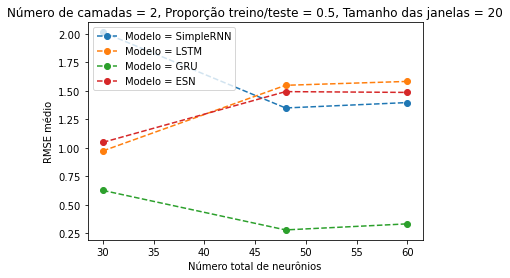

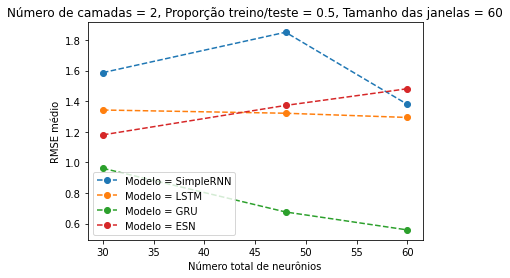

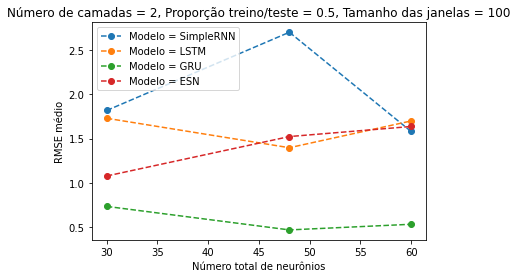

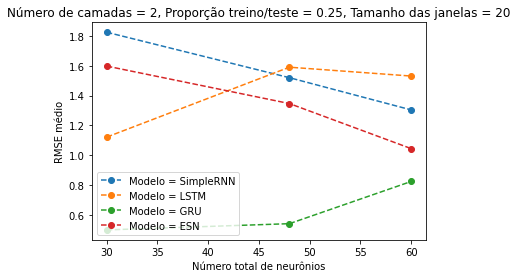

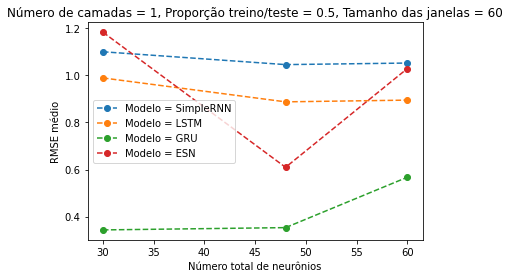

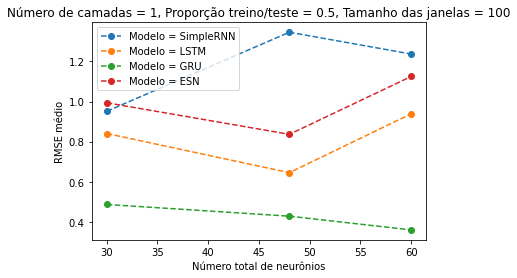

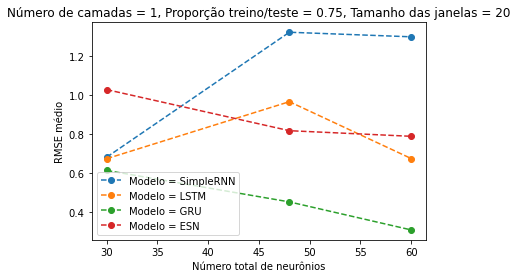

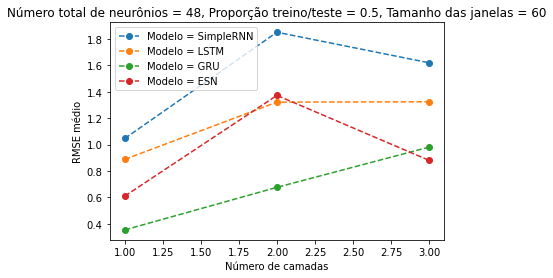

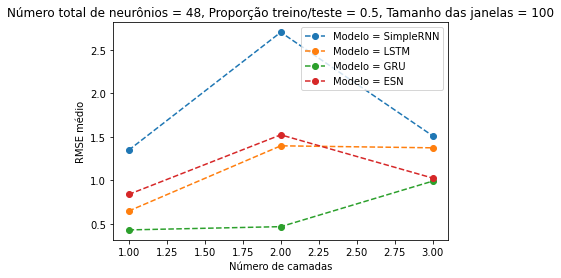

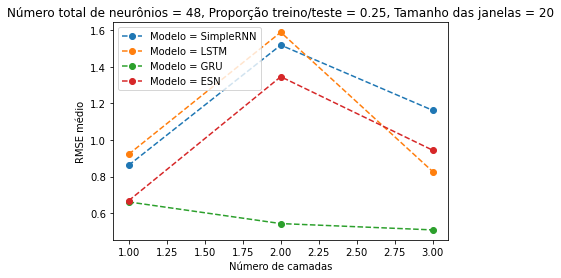

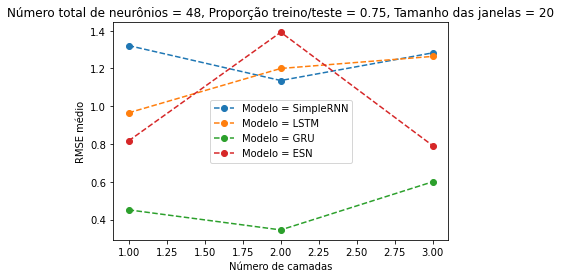

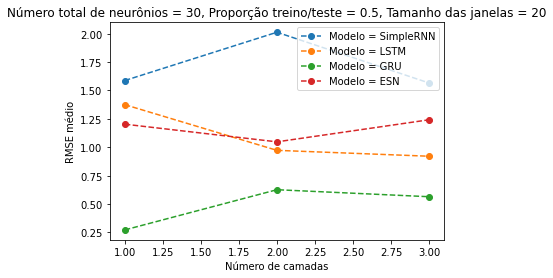

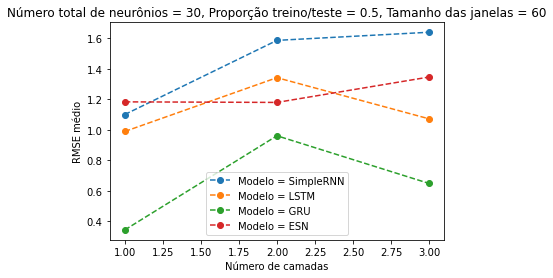

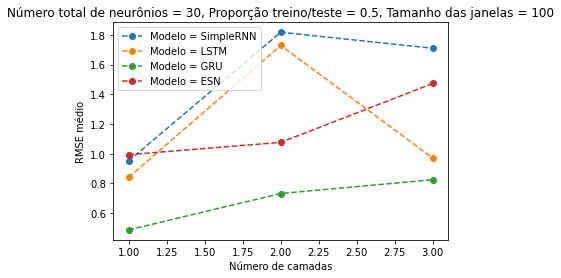

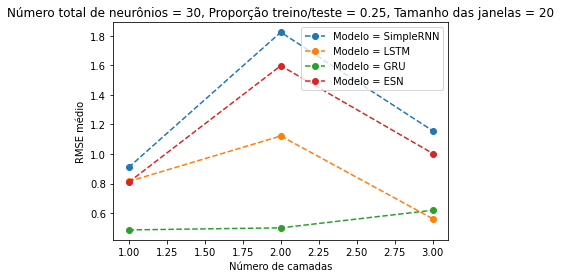

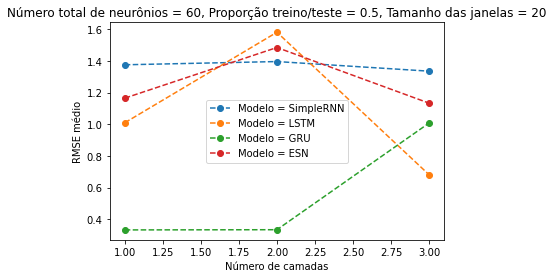

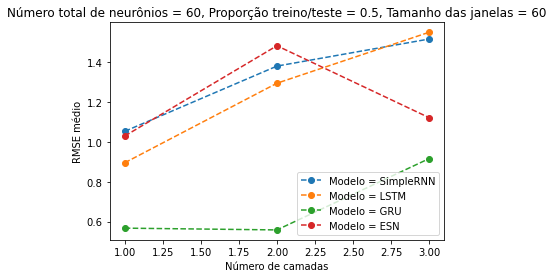

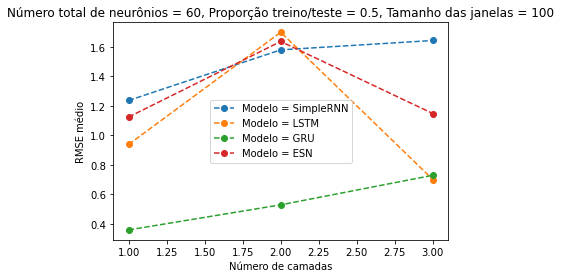

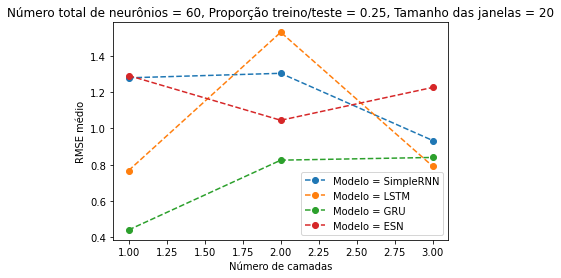

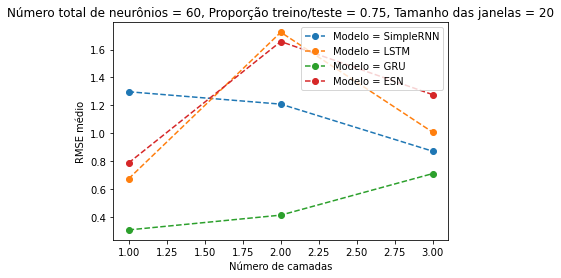

In [7]:
for info in combinacoes_interessantes[-20:]:
    filtro1 = df_resultados[info[0][0]] == info[1][0]
    filtro2 = df_resultados[info[0][1]] == info[1][1]
    filtro3 = df_resultados[info[0][2]] == info[1][2]
    df_resultados_filtrado = df_resultados[(filtro1) & (filtro2) & (filtro3)].reset_index(drop = True)
    
    plt.figure()
    valores_col_parametrizada = info[3][0]
    for valor_parametro in valores_col_parametrizada:
        filtro_parametro = df_resultados_filtrado[info[2][0]] == valor_parametro
        df_resultados_filtrado_parametrizado = df_resultados_filtrado.copy()[filtro_parametro]
        df_resultados_filtrado_parametrizado = df_resultados_filtrado_parametrizado.sort_values(by = info[2][1])
        
        x = df_resultados_filtrado_parametrizado[info[2][1]]
        y = df_resultados_filtrado_parametrizado["RMSE médio"]
        
        titulo_plot = (info[0][0] + " = " + str(info[1][0]) + ", ") + (info[0][1] + " = " + str(info[1][1]) + ", ") + (info[0][2] + " = " + str(info[1][2]))
        label_plot = info[2][0] + " = " + str(valor_parametro)
        
        plt.plot(x,y, label = label_plot, linestyle='--', marker='o' )
        plt.title(titulo_plot)
        plt.xlabel(info[2][1])
        plt.ylabel("RMSE médio")
        plt.legend()
        #y_error = df_resultados_filtrado_parametrizado["Desvio padrão RMSE"]
        #plt.errorbar(x, y, yerr = y_error, fmt="none", alpha = 0.4)
        

In [8]:
pd.set_option('display.max_rows', None)
analise_RMSE = df_resultados.sort_values(by = "RMSE médio").reset_index(drop = True)
analise_RMSE

Modelo  Número de camadas  Número total de neurônios  \
0          GRU                  1                         30   
1          GRU                  2                         48   
2          GRU                  1                         60   
3          GRU                  1                         60   
4          GRU                  2                         60   
5          GRU                  1                         30   
6          GRU                  2                         48   
7          GRU                  1                         48   
8          GRU                  1                         48   
9          GRU                  1                         60   
10         GRU                  2                         60   
11         GRU                  2                         30   
12         GRU                  1                         48   
13         GRU                  1                         60   
14         GRU                  3                         48   
15         GRU                  1                         48   
16         GRU                  2                         48   
17         GRU                  1                         30   
18         GRU                  1                         30   
19         GRU                  2                         30   
20         GRU                  3                         48   
21         GRU                  2                         60   
22         GRU                  2                         48   
23         GRU                  2                         60   
24        LSTM                  3                         30   
25         GRU                  3                         30   
26         GRU                  1                         60   
27         GRU                  3                         48   
28         ESN                  1                         48   
29         GRU                  1                         30   
30        LSTM                  1                         48   
31         GRU                  3                         30   
32         GRU                  2                         30   
33        LSTM                  1                         48   
34         GRU                  3                         30   
35         GRU                  1                         48   
36         ESN                  1                         48   
37        LSTM                  1                         30   
38        LSTM                  1                         60   
39         GRU                  2                         48   
40        LSTM                  3                         60   
41   SimpleRNN                  1                         30   
42        LSTM                  3                         60   
43         GRU                  3                         60   
44         GRU                  3                         60   
45         GRU                  2                         30   
46         ESN                  1                         48   
47        LSTM                  1                         60   
48         ESN                  3                         48   
49         ESN                  1                         60   
50        LSTM                  3                         60   
51         ESN                  3                         48   
52         ESN                  1                         30   
53        LSTM                  1                         30   
54         ESN                  1                         48   
55        LSTM                  3                         48   
56         GRU                  2                         60   
57         GRU                  3                         30   
58        LSTM                  3                         48   
59         ESN                  1                         48   
60         GRU                  3                         60   
61        LSTM                  1       

(array([36.,  0.,  0.,  7.,  0.,  0.,  2.,  0.,  0.,  1.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

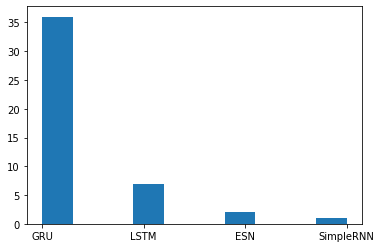

In [9]:
plt.hist(analise_RMSE.loc[:45]["Modelo"])

(array([21.,  0.,  0.,  0.,  0., 12.,  0.,  0.,  0., 12.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

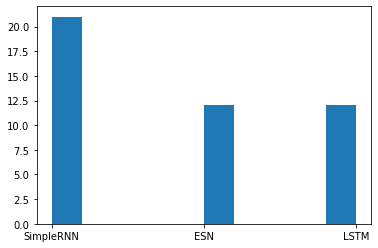

In [10]:
plt.hist(analise_RMSE.loc[135:180]["Modelo"])

(array([10.,  0.,  0., 12.,  0.,  0., 18.,  0.,  0.,  6.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

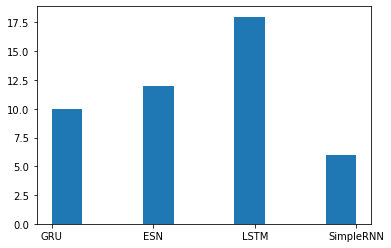

In [11]:
plt.hist(analise_RMSE.loc[45:90]["Modelo"])

(array([20.,  0.,  0.,  0.,  0., 18.,  0.,  0.,  0.,  8.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

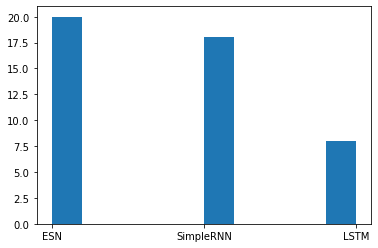

In [12]:
plt.hist(analise_RMSE.loc[90:135]["Modelo"])

(array([10.,  0.,  0., 31.,  0.,  0., 26.,  0.,  0., 24.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

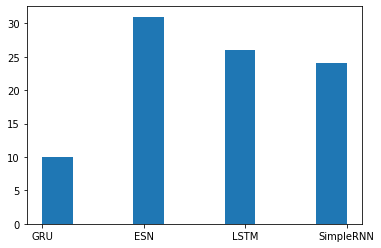

In [13]:
plt.hist(analise_RMSE.loc[45:135]["Modelo"])

In [14]:
df_resultados

Modelo  Número de camadas  Número total de neurônios  \
0    SimpleRNN                  3                         48   
1         LSTM                  3                         48   
2          GRU                  3                         48   
3          ESN                  3                         48   
4    SimpleRNN                  2                         48   
5         LSTM                  2                         48   
6          GRU                  2                         48   
7          ESN                  2                         48   
8    SimpleRNN                  1                         48   
9         LSTM                  1                         48   
10         GRU                  1                         48   
11         ESN                  1                         48   
12   SimpleRNN                  3                         48   
13        LSTM                  3                         48   
14         GRU                  3                         48   
15         ESN                  3                         48   
16   SimpleRNN                  2                         48   
17        LSTM                  2                         48   
18         GRU                  2                         48   
19         ESN                  2                         48   
20   SimpleRNN                  1                         48   
21        LSTM                  1                         48   
22         GRU                  1                         48   
23         ESN                  1                         48   
24   SimpleRNN                  3                         48   
25        LSTM                  3                         48   
26         GRU                  3                         48   
27         ESN                  3                         48   
28   SimpleRNN                  2                         48   
29        LSTM                  2                         48   
30         GRU                  2                         48   
31         ESN                  2                         48   
32   SimpleRNN                  1                         48   
33        LSTM                  1                         48   
34         GRU                  1                         48   
35         ESN                  1                         48   
36   SimpleRNN                  3                         48   
37        LSTM                  3                         48   
38         GRU                  3                         48   
39         ESN                  3                         48   
40   SimpleRNN                  2                         48   
41        LSTM                  2                         48   
42         GRU                  2                         48   
43         ESN                  2                         48   
44   SimpleRNN                  1                         48   
45        LSTM                  1                         48   
46         GRU                  1                         48   
47         ESN                  1                         48   
48   SimpleRNN                  3                         48   
49        LSTM                  3                         48   
50         GRU                  3                         48   
51         ESN                  3                         48   
52   SimpleRNN                  2                         48   
53        LSTM                  2                         48   
54         GRU                  2                         48   
55         ESN                  2                         48   
56   SimpleRNN                  1                         48   
57        LSTM                  1                         48   
58         GRU                  1                         48   
59         ESN                  1                         48   
60   SimpleRNN                  3                         30   
61        LSTM                  3       

## ------------------------------------------------------

## PLOT 1.1

In [18]:
for info in infos_plot:
    filtro1 = df_resultados[info[0][0]] == info[1][0]
    filtro2 = df_resultados[info[0][1]] == info[1][1]
    filtro3 = df_resultados[info[0][2]] == info[1][2]
    df_resultados_filtrado = df_resultados[(filtro1) & (filtro2) & (filtro3)].reset_index(drop = True)
    
    valores_col_parametrizada = info[3][0]
    valores_col_parametrizada.sort()
    
    passador = 0
    plotou = False
    for valor_parametro in valores_col_parametrizada:
        
        titulo_plot = (info[0][0] + " = " + str(info[1][0]) + ", ") + (info[0][1] + " = " + str(info[1][1]) + ", ") + (info[0][2] + " = " + str(info[1][2]))
        
        if titulo_plot == "Número de camadas = 3, Proporção treino/teste = 0.5, Tamanho das janelas = 20":
            
            if passador == 0:
                fig = go.Figure()
                plotou = True
            
            filtro_parametro = df_resultados_filtrado[info[2][0]] == valor_parametro
            df_resultados_filtrado_parametrizado = df_resultados_filtrado.copy()[filtro_parametro]
            df_resultados_filtrado_parametrizado = df_resultados_filtrado_parametrizado.sort_values(by = [info[2][1]])

            x = df_resultados_filtrado_parametrizado[info[2][1]]
            y = df_resultados_filtrado_parametrizado["RMSE médio"]      
            
            label_plot = info[2][0] + " = " + str(valor_parametro)
            
            
            y_error = df_resultados_filtrado_parametrizado["Desvio padrão RMSE"]
            fig.add_trace(go.Bar(
                                x=["30", "48", "60"],
                                y=y,
                                name=label_plot,
                                error_y=dict(type='data', # value of error bar given in data coordinates
                                             array=y_error,
                                             visible=True)
                            ))

            passador += 1
            
    if plotou == True:
        fig.update_layout(title = titulo_plot,
                          title_x=0.119,
                          title_y=0.9,
                          yaxis = dict(title = "RMSE médio"),
                          xaxis = dict(title = info[2][1]),
                          barmode='group',
                          xaxis_tickangle=0)
        fig.show()
    
    passador = 0
    
    
#fonte: https://plotly.com/python/bar-charts/

#### ^^^^^^^ ignore o eixo x do segundo gráfico. Era pra ter os nomes dos modelos, mas isto não é preocupante pois só pegaremos os primeiros gráficos para o TCC. Nos demais plots 2.x e 3.x os nomes dos eixos estão todos certos. Plota-se versões de tamanho maior dos gráficos para que a qualidade das imagens no trabalho fique melhor. 

In [20]:
for info in infos_plot:
    filtro1 = df_resultados[info[0][0]] == info[1][0]
    filtro2 = df_resultados[info[0][1]] == info[1][1]
    filtro3 = df_resultados[info[0][2]] == info[1][2]
    df_resultados_filtrado = df_resultados[(filtro1) & (filtro2) & (filtro3)].reset_index(drop = True)
    
    valores_col_parametrizada = info[3][0]
    valores_col_parametrizada.sort()
    
    passador = 0
    plotou = False
    for valor_parametro in valores_col_parametrizada:
        
        titulo_plot = (info[0][0] + " = " + str(info[1][0]) + ", ") + (info[0][1] + " = " + str(info[1][1]) + ", ") + (info[0][2] + " = " + str(info[1][2]))
        
        if titulo_plot == "Número de camadas = 3, Proporção treino/teste = 0.5, Tamanho das janelas = 20":
            
            if passador == 0:
                fig = go.Figure()
                plotou = True
            
            filtro_parametro = df_resultados_filtrado[info[2][0]] == valor_parametro
            df_resultados_filtrado_parametrizado = df_resultados_filtrado.copy()[filtro_parametro]
            df_resultados_filtrado_parametrizado = df_resultados_filtrado_parametrizado.sort_values(by = [info[2][1]])

            x = df_resultados_filtrado_parametrizado[info[2][1]]
            y = df_resultados_filtrado_parametrizado["RMSE médio"]      
            
            label_plot = info[2][0] + " = " + str(valor_parametro)
            
            
            y_error = df_resultados_filtrado_parametrizado["Desvio padrão RMSE"]
            fig.add_trace(go.Bar(
                                x=["30", "48", "60"],
                                y=y,
                                name=label_plot,
                                error_y=dict(type='data', # value of error bar given in data coordinates
                                             array=y_error,
                                             visible=True)
                            ))

            passador += 1
            
    if plotou == True:
        fig.update_layout(showlegend=False,
                          width=1300,
                          height=800,
                          title_x=0.119,
                          title_y=0.9,
                          yaxis = dict(title = "RMSE médio"),
                          xaxis = dict(title = info[2][1]),
                          barmode='group',
                          xaxis_tickangle=0,
                          font=dict(
                                  family="times new roman",
                                  size=50,
                                  color="black")
                         )
                                                                     
        fig.show()
    
    passador = 0
    
    
#fonte: https://plotly.com/python/bar-charts/

## PLOT 1.2

In [22]:
for info in infos_plot:
    filtro1 = df_resultados[info[0][0]] == info[1][0]
    filtro2 = df_resultados[info[0][1]] == info[1][1]
    filtro3 = df_resultados[info[0][2]] == info[1][2]
    df_resultados_filtrado = df_resultados[(filtro1) & (filtro2) & (filtro3)].reset_index(drop = True)
    
    valores_col_parametrizada = info[3][0]
    valores_col_parametrizada.sort()
    
    passador = 0
    plotou = False
    for valor_parametro in valores_col_parametrizada:
        
        titulo_plot = (info[0][0] + " = " + str(info[1][0]) + ", ") + (info[0][1] + " = " + str(info[1][1]) + ", ") + (info[0][2] + " = " + str(info[1][2]))
        
        if titulo_plot == "Número de camadas = 2, Proporção treino/teste = 0.5, Tamanho das janelas = 20":
            
            if passador == 0:
                fig = go.Figure()
                plotou = True
            
            filtro_parametro = df_resultados_filtrado[info[2][0]] == valor_parametro
            df_resultados_filtrado_parametrizado = df_resultados_filtrado.copy()[filtro_parametro]
            df_resultados_filtrado_parametrizado = df_resultados_filtrado_parametrizado.sort_values(by = [info[2][1]])

            x = df_resultados_filtrado_parametrizado[info[2][1]]
            y = df_resultados_filtrado_parametrizado["RMSE médio"]      
            
            label_plot = info[2][0] + " = " + str(valor_parametro)
            
            
            y_error = df_resultados_filtrado_parametrizado["Desvio padrão RMSE"]
            fig.add_trace(go.Bar(
                                x=["30", "48", "60"],
                                y=y,
                                name=label_plot,
                                error_y=dict(type='data', # value of error bar given in data coordinates
                                             array=y_error,
                                             visible=True)
                            ))

            passador += 1
            
    if plotou == True:
        fig.update_layout(title = titulo_plot,
                          title_x=0.119,
                          title_y=0.9,
                          yaxis = dict(title = "RMSE médio"),
                          xaxis = dict(title = info[2][1]),
                          barmode='group',
                          xaxis_tickangle=0,
                          font=dict(
                                  family="times new roman",
                                  size=14,
                                  color="black")
                         )
        fig.show()
    
    passador = 0
    
    
#fonte: https://plotly.com/python/bar-charts/

In [21]:
for info in infos_plot:
    filtro1 = df_resultados[info[0][0]] == info[1][0]
    filtro2 = df_resultados[info[0][1]] == info[1][1]
    filtro3 = df_resultados[info[0][2]] == info[1][2]
    df_resultados_filtrado = df_resultados[(filtro1) & (filtro2) & (filtro3)].reset_index(drop = True)
    
    valores_col_parametrizada = info[3][0]
    valores_col_parametrizada.sort()
    
    passador = 0
    plotou = False
    for valor_parametro in valores_col_parametrizada:
        
        titulo_plot = (info[0][0] + " = " + str(info[1][0]) + ", ") + (info[0][1] + " = " + str(info[1][1]) + ", ") + (info[0][2] + " = " + str(info[1][2]))
        
        if titulo_plot == "Número de camadas = 2, Proporção treino/teste = 0.5, Tamanho das janelas = 20":
            
            if passador == 0:
                fig = go.Figure()
                plotou = True
            
            filtro_parametro = df_resultados_filtrado[info[2][0]] == valor_parametro
            df_resultados_filtrado_parametrizado = df_resultados_filtrado.copy()[filtro_parametro]
            df_resultados_filtrado_parametrizado = df_resultados_filtrado_parametrizado.sort_values(by = [info[2][1]])

            x = df_resultados_filtrado_parametrizado[info[2][1]]
            y = df_resultados_filtrado_parametrizado["RMSE médio"]      
            
            label_plot = info[2][0] + " = " + str(valor_parametro)
            
            
            y_error = df_resultados_filtrado_parametrizado["Desvio padrão RMSE"]
            fig.add_trace(go.Bar(
                                x=["30", "48", "60"],
                                y=y,
                                name=label_plot,
                                error_y=dict(type='data', # value of error bar given in data coordinates
                                             array=y_error,
                                             visible=True)
                            ))

            passador += 1
            
    if plotou == True:
        fig.update_layout(showlegend=False,
                          width=1300,
                          height=800,
                          title_x=0.119,
                          title_y=0.9,
                          yaxis = dict(title = "RMSE médio"),
                          xaxis = dict(title = info[2][1]),
                          barmode='group',
                          xaxis_tickangle=0,
                          font=dict(
                                  family="times new roman",
                                  size=50,
                                  color="black")
                         )
        fig.show()
    
    passador = 0
    
    
#fonte: https://plotly.com/python/bar-charts/

## PLOT 1.3

In [ ]:
for info in infos_plot:
    filtro1 = df_resultados[info[0][0]] == info[1][0]
    filtro2 = df_resultados[info[0][1]] == info[1][1]
    filtro3 = df_resultados[info[0][2]] == info[1][2]
    df_resultados_filtrado = df_resultados[(filtro1) & (filtro2) & (filtro3)].reset_index(drop = True)
    
    valores_col_parametrizada = info[3][0]
    valores_col_parametrizada.sort()
    
    passador = 0
    plotou = False
    for valor_parametro in valores_col_parametrizada:
        
        titulo_plot = (info[0][0] + " = " + str(info[1][0]) + ", ") + (info[0][1] + " = " + str(info[1][1]) + ", ") + (info[0][2] + " = " + str(info[1][2]))
        
        if titulo_plot == "Número de camadas = 1, Proporção treino/teste = 0.5, Tamanho das janelas = 20":
            
            if passador == 0:
                fig = go.Figure()
                plotou = True
            
            filtro_parametro = df_resultados_filtrado[info[2][0]] == valor_parametro
            df_resultados_filtrado_parametrizado = df_resultados_filtrado.copy()[filtro_parametro]
            df_resultados_filtrado_parametrizado = df_resultados_filtrado_parametrizado.sort_values(by = [info[2][1]])

            x = df_resultados_filtrado_parametrizado[info[2][1]]
            y = df_resultados_filtrado_parametrizado["RMSE médio"]      
            
            label_plot = info[2][0] + " = " + str(valor_parametro)
            
            
            y_error = df_resultados_filtrado_parametrizado["Desvio padrão RMSE"]
            fig.add_trace(go.Bar(
                                x=["30", "48", "60"],
                                y=y,
                                name=label_plot,
                                error_y=dict(type='data', # value of error bar given in data coordinates
                                             array=y_error,
                                             visible=True)
                            ))

            passador += 1
            
    if plotou == True:
        fig.update_layout(title = titulo_plot,
                          title_x=0.119,
                          title_y=0.9,
                          yaxis = dict(title = "RMSE médio"),
                          xaxis = dict(title = info[2][1]),
                          barmode='group',
                          xaxis_tickangle=0,
                          font=dict(
                                  family="times new roman",
                                  size=14,
                                  color="black")
                         )
        fig.show()
    
    passador = 0
    
    
#fonte: https://plotly.com/python/bar-charts/

In [ ]:
for info in infos_plot:
    filtro1 = df_resultados[info[0][0]] == info[1][0]
    filtro2 = df_resultados[info[0][1]] == info[1][1]
    filtro3 = df_resultados[info[0][2]] == info[1][2]
    df_resultados_filtrado = df_resultados[(filtro1) & (filtro2) & (filtro3)].reset_index(drop = True)
    
    valores_col_parametrizada = info[3][0]
    valores_col_parametrizada.sort()
    
    passador = 0
    plotou = False
    for valor_parametro in valores_col_parametrizada:
        
        titulo_plot = (info[0][0] + " = " + str(info[1][0]) + ", ") + (info[0][1] + " = " + str(info[1][1]) + ", ") + (info[0][2] + " = " + str(info[1][2]))
        
        if titulo_plot == "Número de camadas = 1, Proporção treino/teste = 0.5, Tamanho das janelas = 20":
            
            if passador == 0:
                fig = go.Figure()
                plotou = True
            
            filtro_parametro = df_resultados_filtrado[info[2][0]] == valor_parametro
            df_resultados_filtrado_parametrizado = df_resultados_filtrado.copy()[filtro_parametro]
            df_resultados_filtrado_parametrizado = df_resultados_filtrado_parametrizado.sort_values(by = [info[2][1]])

            x = df_resultados_filtrado_parametrizado[info[2][1]]
            y = df_resultados_filtrado_parametrizado["RMSE médio"]      
            
            label_plot = info[2][0] + " = " + str(valor_parametro)
            
            
            y_error = df_resultados_filtrado_parametrizado["Desvio padrão RMSE"]
            fig.add_trace(go.Bar(
                                x=["30", "48", "60"],
                                y=y,
                                name=label_plot,
                                error_y=dict(type='data', # value of error bar given in data coordinates
                                             array=y_error,
                                             visible=True)
                            ))

            passador += 1
            
    if plotou == True:
        fig.update_layout(showlegend=False,
                          width=1300,
                          height=800,
                          title_x=0.119,
                          title_y=0.9,
                          yaxis = dict(title = "RMSE médio"),
                          xaxis = dict(title = info[2][1]),
                          barmode='group',
                          xaxis_tickangle=0,
                          font=dict(
                                  family="times new roman",
                                  size=50,
                                  color="black")
                         )
        fig.show()
    
    passador = 0
    
    
#fonte: https://plotly.com/python/bar-charts/

## PLOT 2.1

In [ ]:
for info in infos_plot:
    filtro1 = df_resultados[info[0][0]] == info[1][0]
    filtro2 = df_resultados[info[0][1]] == info[1][1]
    filtro3 = df_resultados[info[0][2]] == info[1][2]
    df_resultados_filtrado = df_resultados[(filtro1) & (filtro2) & (filtro3)].reset_index(drop = True)
    
    valores_col_parametrizada = info[3][0]
    valores_col_parametrizada.sort()
    
    passador = 0
    plotou = False
    for valor_parametro in valores_col_parametrizada:
        
        titulo_plot = (info[0][0] + " = " + str(info[1][0]) + ", ") + (info[0][1] + " = " + str(info[1][1]) + ", ") + (info[0][2] + " = " + str(info[1][2]))
        
        if titulo_plot == "Número total de neurônios = 30, Proporção treino/teste = 0.5, Tamanho das janelas = 20":
            
            if passador == 0:
                fig = go.Figure()
                plotou = True
            
            filtro_parametro = df_resultados_filtrado[info[2][0]] == valor_parametro
            df_resultados_filtrado_parametrizado = df_resultados_filtrado.copy()[filtro_parametro]
            df_resultados_filtrado_parametrizado = df_resultados_filtrado_parametrizado.sort_values(by = [info[2][1]])

            x = df_resultados_filtrado_parametrizado[info[2][1]]
            y = df_resultados_filtrado_parametrizado["RMSE médio"]      
            
            label_plot = info[2][0] + " = " + str(valor_parametro)
            
            
            y_error = df_resultados_filtrado_parametrizado["Desvio padrão RMSE"]
            fig.add_trace(go.Bar(
                                x=x,
                                y=y,
                                name=label_plot,
                                error_y=dict(type='data', # value of error bar given in data coordinates
                                             array=y_error,
                                             visible=True)
                            ))

            passador += 1
            
    if plotou == True:
        fig.update_layout(title = titulo_plot, 
                          title_x=0.09,
                          title_y=0.9,
                          yaxis = dict(title = "RMSE médio"),
                          xaxis = dict(title = info[2][1]),
                          barmode='group',
                          xaxis_tickangle=0)
        fig.show()
    
    passador = 0
    
    
#fonte: https://plotly.com/python/bar-charts/

## PLOT 2.2

In [ ]:
for info in infos_plot:
    filtro1 = df_resultados[info[0][0]] == info[1][0]
    filtro2 = df_resultados[info[0][1]] == info[1][1]
    filtro3 = df_resultados[info[0][2]] == info[1][2]
    df_resultados_filtrado = df_resultados[(filtro1) & (filtro2) & (filtro3)].reset_index(drop = True)
    
    valores_col_parametrizada = info[3][0]
    valores_col_parametrizada.sort()
    
    passador = 0
    plotou = False
    for valor_parametro in valores_col_parametrizada:
        
        titulo_plot = (info[0][0] + " = " + str(info[1][0]) + ", ") + (info[0][1] + " = " + str(info[1][1]) + ", ") + (info[0][2] + " = " + str(info[1][2]))
        
        if titulo_plot == "Número total de neurônios = 48, Proporção treino/teste = 0.5, Tamanho das janelas = 20":
            
            if passador == 0:
                fig = go.Figure()
                plotou = True
            
            filtro_parametro = df_resultados_filtrado[info[2][0]] == valor_parametro
            df_resultados_filtrado_parametrizado = df_resultados_filtrado.copy()[filtro_parametro]
            df_resultados_filtrado_parametrizado = df_resultados_filtrado_parametrizado.sort_values(by = [info[2][1]])

            x = df_resultados_filtrado_parametrizado[info[2][1]]
            y = df_resultados_filtrado_parametrizado["RMSE médio"]      
            
            label_plot = info[2][0] + " = " + str(valor_parametro)
            
            
            y_error = df_resultados_filtrado_parametrizado["Desvio padrão RMSE"]
            fig.add_trace(go.Bar(
                                x=x,
                                y=y,
                                name=label_plot,
                                error_y=dict(type='data', # value of error bar given in data coordinates
                                             array=y_error,
                                             visible=True)
                            ))

            passador += 1
            
    if plotou == True:
        fig.update_layout(title = titulo_plot, 
                          title_x=0.09,
                          title_y=0.9,
                          yaxis = dict(title = "RMSE médio"),
                          xaxis = dict(title = info[2][1]),
                          barmode='group',
                          xaxis_tickangle=0)
        fig.show()
    
    passador = 0
    
    
#fonte: https://plotly.com/python/bar-charts/

## PLOT 2.3

In [ ]:
for info in infos_plot:
    filtro1 = df_resultados[info[0][0]] == info[1][0]
    filtro2 = df_resultados[info[0][1]] == info[1][1]
    filtro3 = df_resultados[info[0][2]] == info[1][2]
    df_resultados_filtrado = df_resultados[(filtro1) & (filtro2) & (filtro3)].reset_index(drop = True)
    
    valores_col_parametrizada = info[3][0]
    valores_col_parametrizada.sort()
    
    passador = 0
    plotou = False
    for valor_parametro in valores_col_parametrizada:
        
        titulo_plot = (info[0][0] + " = " + str(info[1][0]) + ", ") + (info[0][1] + " = " + str(info[1][1]) + ", ") + (info[0][2] + " = " + str(info[1][2]))
        
        if titulo_plot == "Número total de neurônios = 60, Proporção treino/teste = 0.5, Tamanho das janelas = 20":
            
            if passador == 0:
                fig = go.Figure()
                plotou = True
            
            filtro_parametro = df_resultados_filtrado[info[2][0]] == valor_parametro
            df_resultados_filtrado_parametrizado = df_resultados_filtrado.copy()[filtro_parametro]
            df_resultados_filtrado_parametrizado = df_resultados_filtrado_parametrizado.sort_values(by = [info[2][1]])

            x = df_resultados_filtrado_parametrizado[info[2][1]]
            y = df_resultados_filtrado_parametrizado["RMSE médio"]      
            
            label_plot = info[2][0] + " = " + str(valor_parametro)
            
            
            y_error = df_resultados_filtrado_parametrizado["Desvio padrão RMSE"]
            fig.add_trace(go.Bar(
                                x=x,
                                y=y,
                                name=label_plot,
                                error_y=dict(type='data', # value of error bar given in data coordinates
                                             array=y_error,
                                             visible=True)
                            ))

            passador += 1
            
    if plotou == True:
        fig.update_layout(title = titulo_plot, 
                          title_x=0.09,
                          title_y=0.9,
                          yaxis = dict(title = "RMSE médio"),
                          xaxis = dict(title = info[2][1]),
                          barmode='group',
                          xaxis_tickangle=0)
        fig.show()
    
    passador = 0
    
#fonte: https://plotly.com/python/bar-charts/

In [ ]:
df_resultados.columns

## PLOT 3.1

In [ ]:
for info in infos_plot:
    filtro1 = df_resultados[info[0][0]] == info[1][0]
    filtro2 = df_resultados[info[0][1]] == info[1][1]
    filtro3 = df_resultados[info[0][2]] == info[1][2]
    df_resultados_filtrado = df_resultados[(filtro1) & (filtro2) & (filtro3)].reset_index(drop = True)
    
    valores_col_parametrizada = info[3][0]
    valores_col_parametrizada.sort()
    
    passador = 0
    plotou = False
    for valor_parametro in valores_col_parametrizada:
        
        titulo_plot = (info[0][0] + " = " + str(info[1][0]) + ", ") + (info[0][1] + " = " + str(info[1][1]) + ", ") + (info[0][2] + " = " + str(info[1][2]))
        
        if titulo_plot == "Número de camadas = 3, Número total de neurônios = 30, Tamanho das janelas = 20":
            
            if passador == 0:
                fig = go.Figure()
                plotou = True
            
            filtro_parametro = df_resultados_filtrado[info[2][0]] == valor_parametro
            df_resultados_filtrado_parametrizado = df_resultados_filtrado.copy()[filtro_parametro]
            df_resultados_filtrado_parametrizado = df_resultados_filtrado_parametrizado.sort_values(by = [info[2][1]])

            x = df_resultados_filtrado_parametrizado[info[2][1]]
            y = df_resultados_filtrado_parametrizado["RMSE médio"]      
            
            label_plot = info[2][0] + " = " + str(valor_parametro)
            
            
            y_error = df_resultados_filtrado_parametrizado["Desvio padrão RMSE"]
            fig.add_trace(go.Bar(
                                x=x,
                                y=y,
                                name=label_plot,
                                error_y=dict(type='data', # value of error bar given in data coordinates
                                             array=y_error,
                                             visible=True)
                            ))

            passador += 1
            
    if plotou == True:
        fig.update_layout(title = titulo_plot, 
                          title_x=0.1,
                          title_y=0.9,
                          yaxis = dict(title = "RMSE médio"),
                          xaxis = dict(title = info[2][1]),
                          barmode='group',
                          xaxis_tickangle=0)
        fig.show()
    
    passador = 0
    
#fonte: https://plotly.com/python/bar-charts/

In [ ]:
for info in infos_plot:
    filtro1 = df_resultados[info[0][0]] == info[1][0]
    filtro2 = df_resultados[info[0][1]] == info[1][1]
    filtro3 = df_resultados[info[0][2]] == info[1][2]
    df_resultados_filtrado = df_resultados[(filtro1) & (filtro2) & (filtro3)].reset_index(drop = True)
    
    valores_col_parametrizada = info[3][0]
    valores_col_parametrizada.sort()
    
    passador = 0
    plotou = False
    for valor_parametro in valores_col_parametrizada:
        
        titulo_plot = (info[0][0] + " = " + str(info[1][0]) + ", ") + (info[0][1] + " = " + str(info[1][1]) + ", ") + (info[0][2] + " = " + str(info[1][2]))
        
        if titulo_plot == "Número de camadas = 3, Número total de neurônios = 30, Tamanho das janelas = 20":
            
            if passador == 0:
                fig = go.Figure()
                plotou = True
            
            filtro_parametro = df_resultados_filtrado[info[2][0]] == valor_parametro
            df_resultados_filtrado_parametrizado = df_resultados_filtrado.copy()[filtro_parametro]
            df_resultados_filtrado_parametrizado = df_resultados_filtrado_parametrizado.sort_values(by = [info[2][1]])

            x = df_resultados_filtrado_parametrizado[info[2][1]]
            y = df_resultados_filtrado_parametrizado["RMSE médio"]      
            
            label_plot = info[2][0] + " = " + str(valor_parametro)
            
            
            y_error = df_resultados_filtrado_parametrizado["Desvio padrão RMSE"]
            fig.add_trace(go.Bar(
                                x=x,
                                y=y,
                                name=label_plot,
                                error_y=dict(type='data', # value of error bar given in data coordinates
                                             array=y_error,
                                             visible=True)
                            ))

            passador += 1
            
    if plotou == True:
        fig.update_layout(showlegend=False,
                          width=1300,
                          height=800,
                          title_x=0.119,
                          title_y=0.9,
                          yaxis = dict(title = "RMSE médio"),
                          xaxis = dict(title = info[2][1]),
                          barmode='group',
                          xaxis_tickangle=0,
                          font=dict(
                                  family="times new roman",
                                  size=50,
                                  color="black")
                         )
        fig.show()
    
    passador = 0
    
#fonte: https://plotly.com/python/bar-charts/

## PLOT 3.2

In [ ]:
for info in infos_plot:
    filtro1 = df_resultados[info[0][0]] == info[1][0]
    filtro2 = df_resultados[info[0][1]] == info[1][1]
    filtro3 = df_resultados[info[0][2]] == info[1][2]
    df_resultados_filtrado = df_resultados[(filtro1) & (filtro2) & (filtro3)].reset_index(drop = True)
    
    valores_col_parametrizada = info[3][0]
    valores_col_parametrizada.sort()
    
    passador = 0
    plotou = False
    for valor_parametro in valores_col_parametrizada:
        
        titulo_plot = (info[0][0] + " = " + str(info[1][0]) + ", ") + (info[0][1] + " = " + str(info[1][1]) + ", ") + (info[0][2] + " = " + str(info[1][2]))
        
        if titulo_plot == "Número de camadas = 3, Número total de neurônios = 48, Tamanho das janelas = 20":
            
            if passador == 0:
                fig = go.Figure()
                plotou = True
            
            filtro_parametro = df_resultados_filtrado[info[2][0]] == valor_parametro
            df_resultados_filtrado_parametrizado = df_resultados_filtrado.copy()[filtro_parametro]
            df_resultados_filtrado_parametrizado = df_resultados_filtrado_parametrizado.sort_values(by = [info[2][1]])

            x = df_resultados_filtrado_parametrizado[info[2][1]]
            y = df_resultados_filtrado_parametrizado["RMSE médio"]      
            
            label_plot = info[2][0] + " = " + str(valor_parametro)
            
            
            y_error = df_resultados_filtrado_parametrizado["Desvio padrão RMSE"]
            fig.add_trace(go.Bar(
                                x=x,
                                y=y,
                                name=label_plot,
                                error_y=dict(type='data', # value of error bar given in data coordinates
                                             array=y_error,
                                             visible=True)
                            ))

            passador += 1
            
    if plotou == True:
        fig.update_layout(title = titulo_plot, 
                          title_x=0.1,
                          title_y=0.9,
                          yaxis = dict(title = "RMSE médio"),
                          xaxis = dict(title = info[2][1]),
                          barmode='group',
                          xaxis_tickangle=0)
        fig.show()
    
    passador = 0
    
#fonte: https://plotly.com/python/bar-charts/

In [ ]:
for info in infos_plot:
    filtro1 = df_resultados[info[0][0]] == info[1][0]
    filtro2 = df_resultados[info[0][1]] == info[1][1]
    filtro3 = df_resultados[info[0][2]] == info[1][2]
    df_resultados_filtrado = df_resultados[(filtro1) & (filtro2) & (filtro3)].reset_index(drop = True)
    
    valores_col_parametrizada = info[3][0]
    valores_col_parametrizada.sort()
    
    passador = 0
    plotou = False
    for valor_parametro in valores_col_parametrizada:
        
        titulo_plot = (info[0][0] + " = " + str(info[1][0]) + ", ") + (info[0][1] + " = " + str(info[1][1]) + ", ") + (info[0][2] + " = " + str(info[1][2]))
        
        if titulo_plot == "Número de camadas = 3, Número total de neurônios = 48, Tamanho das janelas = 20":
            
            if passador == 0:
                fig = go.Figure()
                plotou = True
            
            filtro_parametro = df_resultados_filtrado[info[2][0]] == valor_parametro
            df_resultados_filtrado_parametrizado = df_resultados_filtrado.copy()[filtro_parametro]
            df_resultados_filtrado_parametrizado = df_resultados_filtrado_parametrizado.sort_values(by = [info[2][1]])

            x = df_resultados_filtrado_parametrizado[info[2][1]]
            y = df_resultados_filtrado_parametrizado["RMSE médio"]      
            
            label_plot = info[2][0] + " = " + str(valor_parametro)
            
            
            y_error = df_resultados_filtrado_parametrizado["Desvio padrão RMSE"]
            fig.add_trace(go.Bar(
                                x=x,
                                y=y,
                                name=label_plot,
                                error_y=dict(type='data', # value of error bar given in data coordinates
                                             array=y_error,
                                             visible=True)
                            ))

            passador += 1
            
    if plotou == True:
        fig.update_layout(showlegend=False,
                          width=1300,
                          height=800,
                          title_x=0.119,
                          title_y=0.9,
                          yaxis = dict(title = "RMSE médio"),
                          xaxis = dict(title = info[2][1]),
                          barmode='group',
                          xaxis_tickangle=0,
                          font=dict(
                                  family="times new roman",
                                  size=50,
                                  color="black")
                         )

        fig.show()
    
    passador = 0
    
#fonte: https://plotly.com/python/bar-charts/

## PLOT 3.3

In [ ]:
for info in infos_plot:
    filtro1 = df_resultados[info[0][0]] == info[1][0]
    filtro2 = df_resultados[info[0][1]] == info[1][1]
    filtro3 = df_resultados[info[0][2]] == info[1][2]
    df_resultados_filtrado = df_resultados[(filtro1) & (filtro2) & (filtro3)].reset_index(drop = True)
    
    valores_col_parametrizada = info[3][0]
    valores_col_parametrizada.sort()
    
    passador = 0
    plotou = False
    for valor_parametro in valores_col_parametrizada:
        
        titulo_plot = (info[0][0] + " = " + str(info[1][0]) + ", ") + (info[0][1] + " = " + str(info[1][1]) + ", ") + (info[0][2] + " = " + str(info[1][2]))
        
        if titulo_plot == "Número de camadas = 3, Número total de neurônios = 60, Tamanho das janelas = 20":
            
            if passador == 0:
                fig = go.Figure()
                plotou = True
            
            filtro_parametro = df_resultados_filtrado[info[2][0]] == valor_parametro
            df_resultados_filtrado_parametrizado = df_resultados_filtrado.copy()[filtro_parametro]
            df_resultados_filtrado_parametrizado = df_resultados_filtrado_parametrizado.sort_values(by = [info[2][1]])

            x = df_resultados_filtrado_parametrizado[info[2][1]]
            y = df_resultados_filtrado_parametrizado["RMSE médio"]      
            
            label_plot = info[2][0] + " = " + str(valor_parametro)
            
            
            y_error = df_resultados_filtrado_parametrizado["Desvio padrão RMSE"]
            fig.add_trace(go.Bar(
                                x=x,
                                y=y,
                                name=label_plot,
                                error_y=dict(type='data', # value of error bar given in data coordinates
                                             array=y_error,
                                             visible=True)
                            ))

            passador += 1
            
    if plotou == True:
        fig.update_layout(title = titulo_plot, 
                          title_x=0.1,
                          title_y=0.9,
                          yaxis = dict(title = "RMSE médio"),
                          xaxis = dict(title = info[2][1]),
                          barmode='group',
                          xaxis_tickangle=0)
        fig.show()
    
    passador = 0
    
#fonte: https://plotly.com/python/bar-charts/

In [ ]:
for info in infos_plot:
    filtro1 = df_resultados[info[0][0]] == info[1][0]
    filtro2 = df_resultados[info[0][1]] == info[1][1]
    filtro3 = df_resultados[info[0][2]] == info[1][2]
    df_resultados_filtrado = df_resultados[(filtro1) & (filtro2) & (filtro3)].reset_index(drop = True)
    
    valores_col_parametrizada = info[3][0]
    valores_col_parametrizada.sort()
    
    passador = 0
    plotou = False
    for valor_parametro in valores_col_parametrizada:
        
        titulo_plot = (info[0][0] + " = " + str(info[1][0]) + ", ") + (info[0][1] + " = " + str(info[1][1]) + ", ") + (info[0][2] + " = " + str(info[1][2]))
        
        if titulo_plot == "Número de camadas = 3, Número total de neurônios = 60, Tamanho das janelas = 20":
            
            if passador == 0:
                fig = go.Figure()
                plotou = True
            
            filtro_parametro = df_resultados_filtrado[info[2][0]] == valor_parametro
            df_resultados_filtrado_parametrizado = df_resultados_filtrado.copy()[filtro_parametro]
            df_resultados_filtrado_parametrizado = df_resultados_filtrado_parametrizado.sort_values(by = [info[2][1]])

            x = df_resultados_filtrado_parametrizado[info[2][1]]
            y = df_resultados_filtrado_parametrizado["RMSE médio"]      
            
            label_plot = info[2][0] + " = " + str(valor_parametro)
            
            
            y_error = df_resultados_filtrado_parametrizado["Desvio padrão RMSE"]
            fig.add_trace(go.Bar(
                                x=x,
                                y=y,
                                name=label_plot,
                                error_y=dict(type='data', # value of error bar given in data coordinates
                                             array=y_error,
                                             visible=True)
                            ))

            passador += 1
            
    if plotou == True:
        fig.update_layout(showlegend=False,
                          width=1300,
                          height=800,
                          title_x=0.119,
                          title_y=0.9,
                          yaxis = dict(title = "RMSE médio"),
                          xaxis = dict(title = info[2][1]),
                          barmode='group',
                          xaxis_tickangle=0,
                          font=dict(
                                  family="times new roman",
                                  size=50,
                                  color="black")
                         )
        fig.show()
    
    passador = 0
    
#fonte: https://plotly.com/python/bar-charts/

In [ ]:
for info in infos_plot:
    filtro1 = df_resultados[info[0][0]] == info[1][0]
    filtro2 = df_resultados[info[0][1]] == info[1][1]
    filtro3 = df_resultados[info[0][2]] == info[1][2]
    df_resultados_filtrado = df_resultados[(filtro1) & (filtro2) & (filtro3)].reset_index(drop = True)
    
    valores_col_parametrizada = info[3][0]
    valores_col_parametrizada.sort()
    
    passador = 0
    plotou = False
    for valor_parametro in valores_col_parametrizada:
        
        titulo_plot = (info[0][0] + " = " + str(info[1][0]) + ", ") + (info[0][1] + " = " + str(info[1][1]) + ", ") + (info[0][2] + " = " + str(info[1][2]))
        
        if titulo_plot == "Número de camadas = 3, Proporção treino/teste = 0.25, Tamanho das janelas = 20":
            
            if passador == 0:
                fig = go.Figure()
                plotou = True
            
            filtro_parametro = df_resultados_filtrado[info[2][0]] == valor_parametro
            df_resultados_filtrado_parametrizado = df_resultados_filtrado.copy()[filtro_parametro]
            df_resultados_filtrado_parametrizado = df_resultados_filtrado_parametrizado.sort_values(by = [info[2][1]])

            x = df_resultados_filtrado_parametrizado[info[2][1]]
            y = df_resultados_filtrado_parametrizado["RMSE médio"]      
            
            label_plot = info[2][0] + " = " + str(valor_parametro)
            
            
            y_error = df_resultados_filtrado_parametrizado["Desvio padrão RMSE"]
            fig.add_trace(go.Bar(
                                x=x,
                                y=y,
                                name=label_plot,
                                error_y=dict(type='data', # value of error bar given in data coordinates
                                             array=y_error,
                                             visible=True)
                            ))

            passador += 1
            
    if plotou == True:
        fig.update_layout(title = titulo_plot, 
                          title_x=0.1,
                          title_y=0.9,
                          yaxis = dict(title = "RMSE médio"),
                          xaxis = dict(title = info[2][1]),
                          barmode='group',
                          xaxis_tickangle=0)
        fig.show()
    
    passador = 0
    
#fonte: https://plotly.com/python/bar-charts/

In [ ]:
for info in infos_plot:
    filtro1 = df_resultados[info[0][0]] == info[1][0]
    filtro2 = df_resultados[info[0][1]] == info[1][1]
    filtro3 = df_resultados[info[0][2]] == info[1][2]
    df_resultados_filtrado = df_resultados[(filtro1) & (filtro2) & (filtro3)].reset_index(drop = True)
    
    valores_col_parametrizada = info[3][0]
    valores_col_parametrizada.sort()
    
    passador = 0
    plotou = False
    for valor_parametro in valores_col_parametrizada:
        
        titulo_plot = (info[0][0] + " = " + str(info[1][0]) + ", ") + (info[0][1] + " = " + str(info[1][1]) + ", ") + (info[0][2] + " = " + str(info[1][2]))
        
        if titulo_plot == "Número de camadas = 3, Proporção treino/teste = 0.5, Tamanho das janelas = 20":
            
            if passador == 0:
                fig = go.Figure()
                plotou = True
            
            filtro_parametro = df_resultados_filtrado[info[2][0]] == valor_parametro
            df_resultados_filtrado_parametrizado = df_resultados_filtrado.copy()[filtro_parametro]
            df_resultados_filtrado_parametrizado = df_resultados_filtrado_parametrizado.sort_values(by = [info[2][1]])

            x = df_resultados_filtrado_parametrizado[info[2][1]]
            y = df_resultados_filtrado_parametrizado["RMSE médio"]      
            
            label_plot = info[2][0] + " = " + str(valor_parametro)
            
            
            y_error = df_resultados_filtrado_parametrizado["Desvio padrão RMSE"]
            fig.add_trace(go.Bar(
                                x=x,
                                y=y,
                                name=label_plot,
                                error_y=dict(type='data', # value of error bar given in data coordinates
                                             array=y_error,
                                             visible=True)
                            ))

            passador += 1
            
    if plotou == True:
        fig.update_layout(title = titulo_plot, 
                          title_x=0.1,
                          title_y=0.9,
                          yaxis = dict(title = "RMSE médio"),
                          xaxis = dict(title = info[2][1]),
                          barmode='group',
                          xaxis_tickangle=0)
        fig.show()
    
    passador = 0
    
#fonte: https://plotly.com/python/bar-charts/

In [ ]:
for info in infos_plot:
    filtro1 = df_resultados[info[0][0]] == info[1][0]
    filtro2 = df_resultados[info[0][1]] == info[1][1]
    filtro3 = df_resultados[info[0][2]] == info[1][2]
    df_resultados_filtrado = df_resultados[(filtro1) & (filtro2) & (filtro3)].reset_index(drop = True)
    
    valores_col_parametrizada = info[3][0]
    valores_col_parametrizada.sort()
    
    passador = 0
    plotou = False
    for valor_parametro in valores_col_parametrizada:
        
        titulo_plot = (info[0][0] + " = " + str(info[1][0]) + ", ") + (info[0][1] + " = " + str(info[1][1]) + ", ") + (info[0][2] + " = " + str(info[1][2]))
        
        if titulo_plot == "Número de camadas = 3, Proporção treino/teste = 0.75, Tamanho das janelas = 20":
            
            if passador == 0:
                fig = go.Figure()
                plotou = True
            
            filtro_parametro = df_resultados_filtrado[info[2][0]] == valor_parametro
            df_resultados_filtrado_parametrizado = df_resultados_filtrado.copy()[filtro_parametro]
            df_resultados_filtrado_parametrizado = df_resultados_filtrado_parametrizado.sort_values(by = [info[2][1]])

            x = df_resultados_filtrado_parametrizado[info[2][1]]
            y = df_resultados_filtrado_parametrizado["RMSE médio"]      
            
            label_plot = info[2][0] + " = " + str(valor_parametro)
            
            
            y_error = df_resultados_filtrado_parametrizado["Desvio padrão RMSE"]
            fig.add_trace(go.Bar(
                                x=x,
                                y=y,
                                name=label_plot,
                                error_y=dict(type='data', # value of error bar given in data coordinates
                                             array=y_error,
                                             visible=True)
                            ))

            passador += 1
            
    if plotou == True:
        fig.update_layout(title = titulo_plot, 
                          title_x=0.1,
                          title_y=0.9,
                          yaxis = dict(title = "RMSE médio"),
                          xaxis = dict(title = info[2][1]),
                          barmode='group',
                          xaxis_tickangle=0)
        fig.show()
    
    passador = 0
    
#fonte: https://plotly.com/python/bar-charts/

## PLOT 4.1

In [ ]:
for info in infos_plot:
    filtro1 = df_resultados[info[0][0]] == info[1][0]
    filtro2 = df_resultados[info[0][1]] == info[1][1]
    filtro3 = df_resultados[info[0][2]] == info[1][2]
    df_resultados_filtrado = df_resultados[(filtro1) & (filtro2) & (filtro3)].reset_index(drop = True)
    
    valores_col_parametrizada = info[3][0]
    valores_col_parametrizada.sort()
    
    passador = 0
    plotou = False
    for valor_parametro in valores_col_parametrizada:
        
        titulo_plot = (info[0][0] + " = " + str(info[1][0]) + ", ") + (info[0][1] + " = " + str(info[1][1]) + ", ") + (info[0][2] + " = " + str(info[1][2]))
        
        if titulo_plot == "Número de camadas = 3, Número total de neurônios = 30, Proporção treino/teste = 0.5":
            
            if passador == 0:
                fig = go.Figure()
                plotou = True
            
            filtro_parametro = df_resultados_filtrado[info[2][0]] == valor_parametro
            df_resultados_filtrado_parametrizado = df_resultados_filtrado.copy()[filtro_parametro]
            df_resultados_filtrado_parametrizado = df_resultados_filtrado_parametrizado.sort_values(by = [info[2][1]])

            x = df_resultados_filtrado_parametrizado[info[2][1]]
            y = df_resultados_filtrado_parametrizado["RMSE médio"]      
            
            label_plot = info[2][0] + " = " + str(valor_parametro)
            
            
            y_error = df_resultados_filtrado_parametrizado["Desvio padrão RMSE"]
            fig.add_trace(go.Bar(
                                x=x,
                                y=y,
                                name=label_plot,
                                error_y=dict(type='data', # value of error bar given in data coordinates
                                             array=y_error,
                                             visible=True)
                            ))

            passador += 1
            
    if plotou == True:
        fig.update_layout(title = titulo_plot, 
                          title_x=0.095,
                          title_y=0.9,
                          yaxis = dict(title = "RMSE médio"),
                          xaxis = dict(title = info[2][1]),
                          barmode='group',
                          xaxis_tickangle=0)
        fig.show()
    
    passador = 0
    
#fonte: https://plotly.com/python/bar-charts/

In [ ]:
for info in infos_plot:
    filtro1 = df_resultados[info[0][0]] == info[1][0]
    filtro2 = df_resultados[info[0][1]] == info[1][1]
    filtro3 = df_resultados[info[0][2]] == info[1][2]
    df_resultados_filtrado = df_resultados[(filtro1) & (filtro2) & (filtro3)].reset_index(drop = True)
    
    valores_col_parametrizada = info[3][0]
    valores_col_parametrizada.sort()
    
    passador = 0
    plotou = False
    for valor_parametro in valores_col_parametrizada:
        
        titulo_plot = (info[0][0] + " = " + str(info[1][0]) + ", ") + (info[0][1] + " = " + str(info[1][1]) + ", ") + (info[0][2] + " = " + str(info[1][2]))
        
        if titulo_plot == "Número de camadas = 3, Número total de neurônios = 30, Proporção treino/teste = 0.5":
            
            if passador == 0:
                fig = go.Figure()
                plotou = True
            
            filtro_parametro = df_resultados_filtrado[info[2][0]] == valor_parametro
            df_resultados_filtrado_parametrizado = df_resultados_filtrado.copy()[filtro_parametro]
            df_resultados_filtrado_parametrizado = df_resultados_filtrado_parametrizado.sort_values(by = [info[2][1]])

            x = df_resultados_filtrado_parametrizado[info[2][1]]
            y = df_resultados_filtrado_parametrizado["RMSE médio"]      
            
            label_plot = info[2][0] + " = " + str(valor_parametro)
            
            
            y_error = df_resultados_filtrado_parametrizado["Desvio padrão RMSE"]
            fig.add_trace(go.Bar(
                                x=x,
                                y=y,
                                name=label_plot,
                                error_y=dict(type='data', # value of error bar given in data coordinates
                                             array=y_error,
                                             visible=True)
                            ))

            passador += 1
            
    if plotou == True:
        fig.update_layout(showlegend=False,
                          width=1300,
                          height=800,
                          title_x=0.119,
                          title_y=0.9,
                          yaxis = dict(title = "RMSE médio"),
                          xaxis = dict(title = info[2][1]),
                          barmode='group',
                          xaxis_tickangle=0,
                          font=dict(
                                  family="times new roman",
                                  size=50,
                                  color="black")
                         )
        fig.show()
    
    passador = 0
    
#fonte: https://plotly.com/python/bar-charts/

## PLOT 4.2

In [ ]:
for info in infos_plot:
    filtro1 = df_resultados[info[0][0]] == info[1][0]
    filtro2 = df_resultados[info[0][1]] == info[1][1]
    filtro3 = df_resultados[info[0][2]] == info[1][2]
    df_resultados_filtrado = df_resultados[(filtro1) & (filtro2) & (filtro3)].reset_index(drop = True)
    
    valores_col_parametrizada = info[3][0]
    valores_col_parametrizada.sort()
    
    passador = 0
    plotou = False
    for valor_parametro in valores_col_parametrizada:
        
        titulo_plot = (info[0][0] + " = " + str(info[1][0]) + ", ") + (info[0][1] + " = " + str(info[1][1]) + ", ") + (info[0][2] + " = " + str(info[1][2]))
        
        if titulo_plot == "Número de camadas = 3, Número total de neurônios = 48, Proporção treino/teste = 0.5":
            
            if passador == 0:
                fig = go.Figure()
                plotou = True
            
            filtro_parametro = df_resultados_filtrado[info[2][0]] == valor_parametro
            df_resultados_filtrado_parametrizado = df_resultados_filtrado.copy()[filtro_parametro]
            df_resultados_filtrado_parametrizado = df_resultados_filtrado_parametrizado.sort_values(by = [info[2][1]])

            x = df_resultados_filtrado_parametrizado[info[2][1]]
            y = df_resultados_filtrado_parametrizado["RMSE médio"]      
            
            label_plot = info[2][0] + " = " + str(valor_parametro)
            
            
            y_error = df_resultados_filtrado_parametrizado["Desvio padrão RMSE"]
            fig.add_trace(go.Bar(
                                x=x,
                                y=y,
                                name=label_plot,
                                error_y=dict(type='data', # value of error bar given in data coordinates
                                             array=y_error,
                                             visible=True)
                            ))

            passador += 1
            
    if plotou == True:
        fig.update_layout(title = titulo_plot, 
                          title_x=0.095,
                          title_y=0.9,
                          yaxis = dict(title = "RMSE médio"),
                          xaxis = dict(title = info[2][1]),
                          barmode='group',
                          xaxis_tickangle=0)
        fig.show()
    
    passador = 0
    
#fonte: https://plotly.com/python/bar-charts/

In [ ]:
for info in infos_plot:
    filtro1 = df_resultados[info[0][0]] == info[1][0]
    filtro2 = df_resultados[info[0][1]] == info[1][1]
    filtro3 = df_resultados[info[0][2]] == info[1][2]
    df_resultados_filtrado = df_resultados[(filtro1) & (filtro2) & (filtro3)].reset_index(drop = True)
    
    valores_col_parametrizada = info[3][0]
    valores_col_parametrizada.sort()
    
    passador = 0
    plotou = False
    for valor_parametro in valores_col_parametrizada:
        
        titulo_plot = (info[0][0] + " = " + str(info[1][0]) + ", ") + (info[0][1] + " = " + str(info[1][1]) + ", ") + (info[0][2] + " = " + str(info[1][2]))
        
        if titulo_plot == "Número de camadas = 3, Número total de neurônios = 48, Proporção treino/teste = 0.5":
            
            if passador == 0:
                fig = go.Figure()
                plotou = True
            
            filtro_parametro = df_resultados_filtrado[info[2][0]] == valor_parametro
            df_resultados_filtrado_parametrizado = df_resultados_filtrado.copy()[filtro_parametro]
            df_resultados_filtrado_parametrizado = df_resultados_filtrado_parametrizado.sort_values(by = [info[2][1]])

            x = df_resultados_filtrado_parametrizado[info[2][1]]
            y = df_resultados_filtrado_parametrizado["RMSE médio"]      
            
            label_plot = info[2][0] + " = " + str(valor_parametro)
            
            
            y_error = df_resultados_filtrado_parametrizado["Desvio padrão RMSE"]
            fig.add_trace(go.Bar(
                                x=x,
                                y=y,
                                name=label_plot,
                                error_y=dict(type='data', # value of error bar given in data coordinates
                                             array=y_error,
                                             visible=True)
                            ))

            passador += 1
            
    if plotou == True:
        fig.update_layout(showlegend=False,
                          width=1300,
                          height=800,
                          title_x=0.119,
                          title_y=0.9,
                          yaxis = dict(title = "RMSE médio"),
                          xaxis = dict(title = info[2][1]),
                          barmode='group',
                          xaxis_tickangle=0,
                          font=dict(
                                  family="times new roman",
                                  size=50,
                                  color="black")
                         )
        fig.show()
    
    passador = 0
    
#fonte: https://plotly.com/python/bar-charts/

## PLOT 4.3

In [ ]:
for info in infos_plot:
    filtro1 = df_resultados[info[0][0]] == info[1][0]
    filtro2 = df_resultados[info[0][1]] == info[1][1]
    filtro3 = df_resultados[info[0][2]] == info[1][2]
    df_resultados_filtrado = df_resultados[(filtro1) & (filtro2) & (filtro3)].reset_index(drop = True)
    
    valores_col_parametrizada = info[3][0]
    valores_col_parametrizada.sort()
    
    passador = 0
    plotou = False
    for valor_parametro in valores_col_parametrizada:
        
        titulo_plot = (info[0][0] + " = " + str(info[1][0]) + ", ") + (info[0][1] + " = " + str(info[1][1]) + ", ") + (info[0][2] + " = " + str(info[1][2]))
        
        if titulo_plot == "Número de camadas = 3, Número total de neurônios = 60, Proporção treino/teste = 0.5":
            
            if passador == 0:
                fig = go.Figure()
                plotou = True
            
            filtro_parametro = df_resultados_filtrado[info[2][0]] == valor_parametro
            df_resultados_filtrado_parametrizado = df_resultados_filtrado.copy()[filtro_parametro]
            df_resultados_filtrado_parametrizado = df_resultados_filtrado_parametrizado.sort_values(by = [info[2][1]])

            x = df_resultados_filtrado_parametrizado[info[2][1]]
            y = df_resultados_filtrado_parametrizado["RMSE médio"]      
            
            label_plot = info[2][0] + " = " + str(valor_parametro)
            
            
            y_error = df_resultados_filtrado_parametrizado["Desvio padrão RMSE"]
            fig.add_trace(go.Bar(
                                x=x,
                                y=y,
                                name=label_plot,
                                error_y=dict(type='data', # value of error bar given in data coordinates
                                             array=y_error,
                                             visible=True)
                            ))

            passador += 1
            
    if plotou == True:
        fig.update_layout(title = titulo_plot, 
                          title_x=0.095,
                          title_y=0.9,
                          yaxis = dict(title = "RMSE médio"),
                          xaxis = dict(title = info[2][1]),
                          barmode='group',
                          xaxis_tickangle=0)
        fig.show()
    
    passador = 0
    
#fonte: https://plotly.com/python/bar-charts/

In [ ]:
for info in infos_plot:
    filtro1 = df_resultados[info[0][0]] == info[1][0]
    filtro2 = df_resultados[info[0][1]] == info[1][1]
    filtro3 = df_resultados[info[0][2]] == info[1][2]
    df_resultados_filtrado = df_resultados[(filtro1) & (filtro2) & (filtro3)].reset_index(drop = True)
    
    valores_col_parametrizada = info[3][0]
    valores_col_parametrizada.sort()
    
    passador = 0
    plotou = False
    for valor_parametro in valores_col_parametrizada:
        
        titulo_plot = (info[0][0] + " = " + str(info[1][0]) + ", ") + (info[0][1] + " = " + str(info[1][1]) + ", ") + (info[0][2] + " = " + str(info[1][2]))
        
        if titulo_plot == "Número de camadas = 3, Número total de neurônios = 60, Proporção treino/teste = 0.5":
            
            if passador == 0:
                fig = go.Figure()
                plotou = True
            
            filtro_parametro = df_resultados_filtrado[info[2][0]] == valor_parametro
            df_resultados_filtrado_parametrizado = df_resultados_filtrado.copy()[filtro_parametro]
            df_resultados_filtrado_parametrizado = df_resultados_filtrado_parametrizado.sort_values(by = [info[2][1]])

            x = df_resultados_filtrado_parametrizado[info[2][1]]
            y = df_resultados_filtrado_parametrizado["RMSE médio"]      
            
            label_plot = info[2][0] + " = " + str(valor_parametro)
            
            
            y_error = df_resultados_filtrado_parametrizado["Desvio padrão RMSE"]
            fig.add_trace(go.Bar(
                                x=x,
                                y=y,
                                name=label_plot,
                                error_y=dict(type='data', # value of error bar given in data coordinates
                                             array=y_error,
                                             visible=True)
                            ))

            passador += 1
            
    if plotou == True:
        fig.update_layout(showlegend=False,
                          width=1300,
                          height=800,
                          title_x=0.119,
                          title_y=0.9,
                          yaxis = dict(title = "RMSE médio"),
                          xaxis = dict(title = info[2][1]),
                          barmode='group',
                          xaxis_tickangle=0,
                          font=dict(
                                  family="times new roman",
                                  size=50,
                                  color="black")
                         )
        fig.show()
    
    passador = 0
    
#fonte: https://plotly.com/python/bar-charts/

## ----------------------------------------------------------------

# Melhores e piores plots

In [23]:
df_resultados.sort_values(by = 'RMSE médio').head(20)

Modelo  Número de camadas  Número total de neurônios  \
70     GRU                  1                         30   
6      GRU                  2                         48   
169    GRU                  1                         60   
121    GRU                  1                         60   
129    GRU                  2                         60   
82     GRU                  1                         30   
54     GRU                  2                         48   
22     GRU                  1                         48   
10     GRU                  1                         48   
145    GRU                  1                         60   
177    GRU                  2                         60   
114    GRU                  2                         30   
34     GRU                  1                         48   
157    GRU                  1                         60   
2      GRU                  3                         48   
58     GRU                  1                         48   
30     GRU                  2                         48   
106    GRU                  1                         30   
94     GRU                  1                         30   
102    GRU                  2                         30   

     Proporção treino/teste  Tamanho das janelas  RMSE médio  \
70                     0.50                   20    0.272417   
6                      0.50                   20    0.280139   
169                    0.75                   20    0.308135   
121                    0.50                   20    0.331964   
129                    0.50                   20    0.333277   
82                     0.50                   60    0.343143   
54                     0.75                   20    0.345491   
22                     0.50                   60    0.352904   
10                     0.50                   20    0.353299   
145                    0.50                  100    0.360065   
177                    0.75                   20    0.414048   
114                    0.75                   20    0.425802   
34                     0.50                  100    0.428517   
157                    0.25                   20    0.440116   
2                      0.50                   20    0.450891   
58                     0.75                   20    0.451752   
30                     0.50                  100    0.466062   
106                    0.25                   20    0.486707   
94                     0.50                  100    0.486934   
102                    0.25                   20    0.500662   

     Desvio padrão RMSE  
70             0.086851  
6              0.038212  
169            0.054200  
121            0.142001  
129            0.121716  
82             0.086214  
54             0.135790  
22             0.136688  
10             0.098327  
145            0.098650  
177            0.087352  
114            0.138606  
34             0.118733  
157            0.036558  
2              0.167514  
58             0.136609  
30             0.208574  
106            0.126796  
94             0.089805  
102            0.052468

In [24]:
df_resultados.sort_values(by = 'RMSE médio').tail(20)

Modelo  Número de camadas  Número total de neurônios  \
151  SimpleRNN                  2                         60   
128       LSTM                  2                         60   
76   SimpleRNN                  2                         30   
68   SimpleRNN                  1                         30   
41        LSTM                  2                         48   
103        ESN                  2                         30   
12   SimpleRNN                  3                         48   
154        ESN                  2                         60   
72   SimpleRNN                  3                         30   
147  SimpleRNN                  3                         60   
178        ESN                  2                         60   
152       LSTM                  2                         60   
84   SimpleRNN                  3                         30   
176       LSTM                  2                         60   
89        LSTM                  2                         30   
88   SimpleRNN                  2                         30   
100  SimpleRNN                  2                         30   
16   SimpleRNN                  2                         48   
64   SimpleRNN                  2                         30   
28   SimpleRNN                  2                         48   

     Proporção treino/teste  Tamanho das janelas  RMSE médio  \
151                    0.50                  100    1.579791   
128                    0.50                   20    1.581872   
76                     0.50                   60    1.587339   
68                     0.50                   20    1.587627   
41                     0.25                   20    1.589914   
103                    0.25                   20    1.597281   
12                     0.50                   60    1.619768   
154                    0.50                  100    1.636546   
72                     0.50                   60    1.640726   
147                    0.50                  100    1.643173   
178                    0.75                   20    1.657526   
152                    0.50                  100    1.699009   
84                     0.50                  100    1.710201   
176                    0.75                   20    1.724059   
89                     0.50                  100    1.729306   
88                     0.50                  100    1.818103   
100                    0.25                   20    1.823851   
16                     0.50                   60    1.851260   
64                     0.50                   20    2.012887   
28                     0.50                  100    2.702927   

     Desvio padrão RMSE  
151            0.448795  
128            0.093145  
76             0.479800  
68             0.421969  
41             0.208382  
103            1.266092  
12             0.040029  
154            0.716018  
72             0.149621  
147            0.179174  
178            1.007652  
152            0.375357  
84             0.215209  
176            0.118844  
89             0.139582  
88             0.451319  
100            0.207755  
16             0.535336  
64             0.160191  
28             0.969889

### 3 melhores e 3 piores de cada modelo

In [ ]:
df_resultados[df_resultados["Modelo"] == "SimpleRNN"].sort_values(by = 'RMSE médio').head(3)

In [ ]:
df_resultados[df_resultados["Modelo"] == "SimpleRNN"].sort_values(by = 'RMSE médio').tail(3)

In [ ]:
df_resultados[df_resultados["Modelo"] == "LSTM"].sort_values(by = 'RMSE médio').head(3)

In [ ]:
df_resultados[df_resultados["Modelo"] == "LSTM"].sort_values(by = 'RMSE médio').tail(3)

In [ ]:
df_resultados[df_resultados["Modelo"] == "GRU"].sort_values(by = 'RMSE médio').head(3)

In [ ]:
df_resultados[df_resultados["Modelo"] == "GRU"].sort_values(by = 'RMSE médio').tail(3)

In [ ]:
df_resultados[df_resultados["Modelo"] == "ESN"].sort_values(by = 'RMSE médio').head(3)

In [ ]:
df_resultados[df_resultados["Modelo"] == "ESN"].sort_values(by = 'RMSE médio').tail(3)

### Fazendo plot dos 3 melhores e dos 3 piores:

In [ ]:
path = "Dados 3 melhores e 3 piores"
arquivos_excel = [f for f in listdir(path) if isfile(join(path, f))]
arquivos_excel

In [ ]:
path_excel = "Dados 3 melhores e 3 piores" + "/" + arquivos_excel[0]
df = pd.read_excel(path_excel, sheet_name = 'predicoes one-step')
df

In [ ]:
Modelo	Número de camadas	Número total de neurônios	Proporção treino/teste	Tamanho das janelas	RMSE médio	Desvio padrão RMSE
116	SimpleRNN	1	30	0.75	20	0.681317	0.175234

In [ ]:
	Modelo	Número de camadas	Número total de neurônios	Proporção treino/teste	Tamanho das janelas	RMSE médio	Desvio padrão RMSE
97	LSTM	3	30	0.25	20	0.561674	0.034927

In [ ]:
	Modelo	Número de camadas	Número total de neurônios	Proporção treino/teste	Tamanho das janelas	RMSE médio	Desvio padrão RMSE
70	GRU	1	30	0.50	20	0.272417	0.086851

In [ ]:
	Modelo	Número de camadas	Número total de neurônios	Proporção treino/teste	Tamanho das janelas	RMSE médio	Desvio padrão RMSE
23	ESN	1	48	0.50	60	0.609338	0.204623

In [ ]:
path_excel = "Dados 3 melhores e 3 piores" + "/" + arquivos_excel[0]
df_multi_step = pd.read_excel(path_excel, sheet_name = 'predicoes multi-step')
df_multi_step

In [ ]:
f1 = df_resultados["Modelo"] == "ESN"
f2 = df_resultados["Número de camadas"] == 3
f3 = df_resultados["Número total de neurônios"] == 60

df_resultados[(f1) & (f2) & (f3)]

In [2]:
df_resultados = pd.read_excel("df_resultados_RMSEs.xlsx")
df_resultados = df_resultados.drop(columns = 'Unnamed: 0')
df_resultados = df_resultados.rename(columns = {"Modelo Algoritmo": "Modelo", "Número camadas": "Número de camadas", 
                                "Número total neurônios": "Número total de neurônios",
                                "Proporcao treino teste": "Proporção treino/teste",
                                "Tamanho janela": "Tamanho das janelas",
                                "RMSE medio": "RMSE médio",
                                "Desvio padrao RMSE": "Desvio padrão RMSE"})

df_resultados

Modelo  Número de camadas  Número total de neurônios  \
0    SimpleRNN                  3                         48   
1         LSTM                  3                         48   
2          GRU                  3                         48   
3          ESN                  3                         48   
4    SimpleRNN                  2                         48   
..         ...                ...                        ...   
175  SimpleRNN                  2                         60   
176       LSTM                  2                         60   
177        GRU                  2                         60   
178        ESN                  2                         60   
179  SimpleRNN                  1                         60   

     Proporção treino/teste  Tamanho das janelas  RMSE médio  \
0                      0.50                   20    0.963568   
1                      0.50                   20    0.819053   
2                      0.50                   20    0.450891   
3                      0.50                   20    0.777760   
4                      0.50                   20    1.349156   
..                      ...                  ...         ...   
175                    0.75                   20    1.209116   
176                    0.75                   20    1.724059   
177                    0.75                   20    0.414048   
178                    0.75                   20    1.657526   
179                    0.75                   20    1.297936   

     Desvio padrão RMSE  
0              0.483722  
1              0.368387  
2              0.167514  
3              0.286317  
4              0.570979  
..                  ...  
175            0.198667  
176            0.118844  
177            0.087352  
178            1.007652  
179            0.528964  

[180 rows x 7 columns]

PROP 0.25: batches_teste	[ 2  3  5  6  9 11 13 15 17 19 21 22 23 24 25 27]

PROP 0.5: batches_teste	[ 3  5  6 11 13 15 17 19 22 23 27]

PROP 0.75: batches_teste	[ 5  6 11 13 19 22]

Ou seja, se for fazer gráficos comparativos quanto ao resultado dos melhores modelos para cada batch, você pode escolher dentre os batches [ 5  6 11 13 19 22]

In [6]:
for i in ["SimpleRNN", "LSTM", "GRU", "ESN"]:
    f1 = df_resultados["Modelo"] == i
    display(df_resultados[f1].sort_values(by = "RMSE médio").head(1))

Modelo  Número de camadas  Número total de neurônios  \
116  SimpleRNN                  1                         30   

     Proporção treino/teste  Tamanho das janelas  RMSE médio  \
116                    0.75                   20    0.681317   

     Desvio padrão RMSE  
116            0.175234

Modelo  Número de camadas  Número total de neurônios  \
97   LSTM                  3                         30   

    Proporção treino/teste  Tamanho das janelas  RMSE médio  \
97                    0.25                   20    0.561674   

    Desvio padrão RMSE  
97            0.034927

Modelo  Número de camadas  Número total de neurônios  \
70    GRU                  1                         30   

    Proporção treino/teste  Tamanho das janelas  RMSE médio  \
70                     0.5                   20    0.272417   

    Desvio padrão RMSE  
70            0.086851

Modelo  Número de camadas  Número total de neurônios  \
23    ESN                  1                         48   

    Proporção treino/teste  Tamanho das janelas  RMSE médio  \
23                     0.5                   60    0.609338   

    Desvio padrão RMSE  
23            0.204623

Melhores configurações de cada modelo:

Modelo	Número de camadas	Número total de neurônios	Proporção treino/teste	Tamanho das janelas	RMSE médio	Desvio padrão RMSE

SimpleRNN	1	30	0.75	20	0.681317	0.175234

Modelo	Número de camadas	Número total de neurônios	Proporção treino/teste	Tamanho das janelas	RMSE médio	Desvio padrão RMSE

LSTM	3	30	0.25	20	0.561674	0.034927

Modelo	Número de camadas	Número total de neurônios	Proporção treino/teste	Tamanho das janelas	RMSE médio	Desvio padrão RMSE

GRU	1	30	0.5	20	0.272417	0.086851

Modelo	Número de camadas	Número total de neurônios	Proporção treino/teste	Tamanho das janelas	RMSE médio	Desvio padrão RMSE

ESN	1	48	0.5	60	0.609338	0.204623

Na coluna Y_teste da planilha "predicoes one-step", cada batch corresponde a 1130 linhas. Contudo, as predições multi-step só predizem até o dado de número 1129, ou seja, não prediz o último elemento. Sendo assim, para fazer o plot comparativo correto, devemos descartar o último elemento de cada batch. Agora, quero plotar os batches 5 6 11 13 19 22. Como as janelas do melhor ESN possuem 60 linhas, todos os plots começarão a partir da conc. de penicilina de número 61. O último valor não será considerado, já que as predições multi-step não o predizem (só vão até o penúltimo elemento).

In [16]:
start_time = time.time()
data = pd.read_csv(r"C:\Users\Felipe.DESKTOP-84PH21R\TCC_POLI\fermentacao\dados\Mendeley_data\100_Batches_IndPenSim_V3.csv")
print("--- %s seconds ---" % (time.time() - start_time))
#r"C:\Users\Felipe.DESKTOP-84PH21R\TCC_POLI\fermentacao\dados\Mendeley_data\100_Batches_IndPenSim_V3.csv"

--- 126.71084022521973 seconds ---


In [17]:
l = data[data['Time (h)']==0.2].index.to_list()
batches_list=[]
for idx in range(0, len(l)):
    if idx+1 <= len(l)-1:
        batches_list.append(data.loc[l[idx]:(l[idx+1]-1)])
    else:
        batches_list.append(data.loc[l[idx]:])

In [18]:
duracao_minima = batches_list[29].shape[0]
batches_utilizados = []

for i in range(0,30):
    if batches_list[i].shape[0] >= duracao_minima:
        batches_utilizados.append(i)
        batches_list[i] = batches_list[i][:duracao_minima]  # Atualizamos os dados para estes batches em batches_list

colunas_utilizaveis = [
 'Time (h)',
 'Aeration rate(Fg:L/h)',
 'Agitator RPM(RPM:RPM)',
 'Sugar feed rate(Fs:L/h)',
 'Acid flow rate(Fa:L/h)',
 'Base flow rate(Fb:L/h)',
 'Heating/cooling water flow rate(Fc:L/h)',
 'Heating water flow rate(Fh:L/h)',
 'Water for injection/dilution(Fw:L/h)',
 'Air head pressure(pressure:bar)',
 'Dumped broth flow(Fremoved:L/h)',
 'Substrate concentration(S:g/L)',
 'Dissolved oxygen concentration(DO2:mg/L)',
 'Penicillin concentration(P:g/L)',
 'Vessel Volume(V:L)',
 'Vessel Weight(Wt:Kg)',
 'pH(pH:pH)',
 'Temperature(T:K)',
 'Generated heat(Q:kJ)',
 'carbon dioxide percent in off-gas(CO2outgas:%)',
 'PAA flow(Fpaa:PAA flow (L/h))',
 'PAA concentration offline(PAA_offline:PAA (g L^{-1}))',
 'Oil flow(Foil:L/hr)',
 'NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))',
 'Oxygen Uptake Rate(OUR:(g min^{-1}))',
 'Oxygen in percent in off-gas(O2:O2  (%))',
 'Offline Penicillin concentration(P_offline:P(g L^{-1}))',
 'Offline Biomass concentratio(X_offline:X(g L^{-1}))',
 'Carbon evolution rate(CER:g/h)',
 'Ammonia shots(NH3_shots:kgs)',
 'Viscosity(Viscosity_offline:centPoise)']

ultimos_valores_penic_batches_utilizados = []
for i in batches_utilizados:
    ultimos_valores_penic_batches_utilizados.append(batches_list[i]['Penicillin concentration(P:g/L)'].to_list()[-1])

ultimos_valores_penic_batches_utilizados = pd.DataFrame(ultimos_valores_penic_batches_utilizados, batches_utilizados)
ultimos_valores_penic_batches_utilizados = ultimos_valores_penic_batches_utilizados.sort_values(by = 0, ascending = False)

batches_maior_penic = ultimos_valores_penic_batches_utilizados.index[[0,1]].to_list()
batches_menor_penic = ultimos_valores_penic_batches_utilizados.index[[-1,-2]].to_list()
print(batches_maior_penic)
print(batches_menor_penic)

import random
rng = np.random.RandomState(42)
batches_utilizados = np.array(batches_utilizados)

proporcao_treino = 0.75
batches_garantidos_no_treino = np.array(batches_maior_penic + batches_menor_penic)

qntd_randomizada_treino = int(  (len(batches_utilizados) * proporcao_treino - len(batches_garantidos_no_treino) )  )
                              
batches_randomizados_treino = rng.choice(np.setxor1d(batches_utilizados, batches_garantidos_no_treino), qntd_randomizada_treino, replace=False) 
# A função np.setxor1d retorna um array com os valores que encontram-se APENAS no primeiro array fornecido. Ou seja, pega o 
# primeiro array e retira os valores que estão no segundo array. https://numpy.org/doc/stable/reference/generated/numpy.setxor1d.html

batches_treino = np.concatenate((batches_randomizados_treino, batches_garantidos_no_treino))

print(len(batches_treino))
batches_treino

batches_teste = np.setxor1d(batches_utilizados, batches_treino)
print(len(batches_teste))
batches_teste

colunas_input = ['Carbon evolution rate(CER:g/h)',
                 'Oxygen Uptake Rate(OUR:(g min^{-1}))', 
                 'Substrate concentration(S:g/L)', 
                 'Penicillin concentration(P:g/L)' ,
                 "Time (h)"]

qntd_features_input = len(colunas_input)

colunas_output = ['Penicillin concentration(P:g/L)']

#colunas_utilizadas = np.union1d(colunas_input, colunas_output)
colunas_utilizadas = colunas_input

[7, 28]
[8, 29]
15
6


In [29]:
for i in batches_utilizados:
    globals()['dados_batch_'+str(i)] = globals()['batches_list'][i].copy().reset_index()[colunas_utilizadas]

# Para fazer o StandardScaling, preciso juntar todos os dados em uma só tabela. Farei o fit para essa tabelona, e, depois, o
# transform para cada tabela em separado.

# FAZENDO O FIT:

passador = 1

for i in batches_treino:
    
    if passador == 2:
    
        df_1 = globals()['dados_batch_%i' %i]
        df_2 = globals()['dados_batch_%i' %i_anterior]
        
        todos_batches_treino = pd.concat([df_1, df_2], sort=False)

    else:
        
        if passador > 2:
            
            df = globals()['dados_batch_%i' %i]
            todos_batches_treino = pd.concat([todos_batches_treino, df], sort=False)
            
    i_anterior = i                                                                                                                                                                                     
    passador += 1

colunas = todos_batches_treino.columns


scaler = StandardScaler()
todos_batches_treino_scaled = scaler.fit(todos_batches_treino)


# FAZENDO O TRANSFORM PARA CADA BATCH (TANTO TREINO QUANTO TESTE):

for i in batches_utilizados:
    temporario = globals()['dados_batch_'+str(i)].copy()
    escalado = pd.DataFrame(scaler.transform(temporario), columns = colunas).copy()
    
    globals()['dados_batch_'+str(i)] = escalado 

In [30]:
dados_batch_5

Carbon evolution rate(CER:g/h)  Oxygen Uptake Rate(OUR:(g min^{-1}))  \
0                          -2.564653                             -2.611790   
1                          -2.555688                             -2.751235   
2                          -2.552693                             -2.773686   
3                          -2.550862                             -2.766538   
4                          -2.549207                             -2.750551   
...                              ...                                   ...   
1145                       -0.202840                             -0.560069   
1146                       -0.204124                             -0.522847   
1147                       -0.205195                             -0.565098   
1148                       -0.206480                             -0.582377   
1149                       -0.207764                             -0.590909   

      Substrate concentration(S:g/L)  Penicillin concentration(P:g/L)  
0                          -0.313016                        -1.467513  
1                          -0.309161                        -1.467513  
2                          -0.305414                        -1.467513  
3                          -0.301790                        -1.467513  
4                          -0.298257                        -1.467513  
...                              ...                              ...  
1145                        2.943120                        -0.080579  
1146                        2.950952                        -0.082437  
1147                        2.958708                        -0.084295  
1148                        2.966464                        -0.086153  
1149                        2.974066                        -0.088010  

[1150 rows x 4 columns]

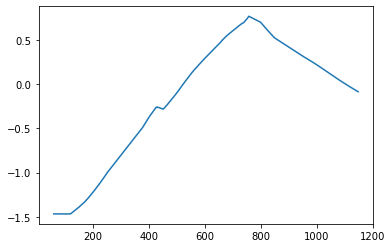

In [47]:
plt.plot(dados_batch_5["Penicillin concentration(P:g/L)"].iloc[60:-1])

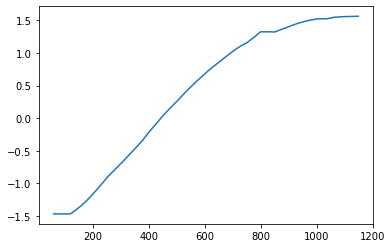

In [137]:
plt.plot(dados_batch_6["Penicillin concentration(P:g/L)"].iloc[60:-1])

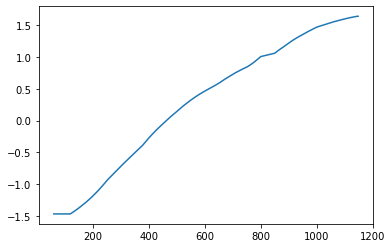

In [138]:
plt.plot(dados_batch_11["Penicillin concentration(P:g/L)"].iloc[60:-1])

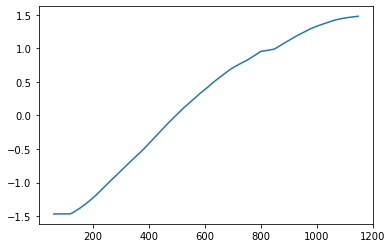

In [139]:
plt.plot(dados_batch_13["Penicillin concentration(P:g/L)"].iloc[60:-1])

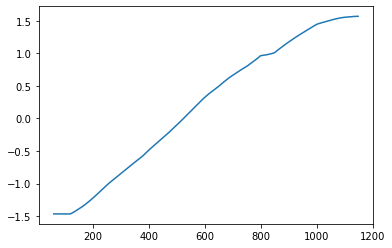

In [140]:
plt.plot(dados_batch_19["Penicillin concentration(P:g/L)"].iloc[60:-1])

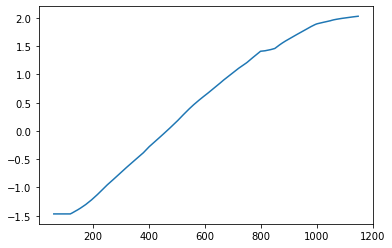

In [141]:
plt.plot(dados_batch_22["Penicillin concentration(P:g/L)"].iloc[60:-1])

In [32]:
len(dados_batch_5["Penicillin concentration(P:g/L)"].iloc[61:-1])

1088

In [33]:
path = "Dados melhores cada modelo"
arquivos_excel = [f for f in listdir(path) if isfile(join(path, f))]
arquivos_excel

['1.Modelo36_G_0_0_30_resultados.xlsx',
 '2.Modelo27_L_L_L_30_resultados.xlsx',
 '3.Modelo24_E_0_0_48_resultados.xlsx',
 '4.Modelo34_S_0_0_30_resultados.xlsx',
 '~$4.Modelo34_S_0_0_30_resultados.xlsx']

Sempre que for fazer o plot dos dados reais, use .iloc[60:-1]. Agora, quando for plotar a predição multi-step, depende: se for pro SimpleRNN, LSTM ou GRU, faça .iloc[40:]. Se for pro ESN, não dê .iloc.

In [70]:
path_excel = "Dados melhores cada modelo" + "/" + arquivos_excel[3]
df = pd.read_excel(path_excel, sheet_name = 'predicoes multi-step')
df["predicoes multi-step replica " + melhores_replicas_por_arquivo[3] + ", batch " + num_batch]

0      -1.467037
1      -1.466325
2      -1.465561
3      -1.464799
4      -1.464077
          ...   
1124    0.364993
1125    0.364119
1126    0.363103
1127    0.362007
1128    0.360897
Name: predicoes multi-step replica 3, batch 5, Length: 1129, dtype: float64

In [54]:
len(dados_batch_5["Penicillin concentration(P:g/L)"].iloc[60:-1])

1089

In [55]:
len(df["predicoes multi-step replica " + melhores_replicas_por_arquivo[0] + ", batch " + num_batch][40:])

1089

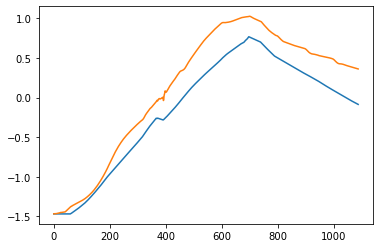

In [71]:
plt.plot(dados_batch_5["Penicillin concentration(P:g/L)"].iloc[60:-1].reset_index(drop = True))
plt.plot(df["predicoes multi-step replica " + melhores_replicas_por_arquivo[3] + ", batch " + num_batch][40:].reset_index(drop = True))

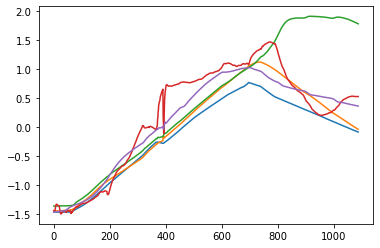

In [73]:
melhores_replicas_por_arquivo = ["2","2","3","3"]
fazer_iloc = [True, True, False, True]
num_batches = ["5"]

for num_batch in num_batches:
    passador_replicas = 0
    passador_iloc = 0
    plt.plot(globals()["dados_batch_"+num_batch]["Penicillin concentration(P:g/L)"].iloc[60:-1].reset_index(drop = True))

    for arquivo_excel in arquivos_excel[:-1]:
        
        path_excel = "Dados melhores cada modelo" + "/" + arquivo_excel
        df = pd.read_excel(path_excel, sheet_name = 'predicoes multi-step')
        predicoes_modelo = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch]
        
        if fazer_iloc[passador_iloc] == True:
            y = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch][40:].reset_index(drop = True)
            plt.plot(y)
            
        else:
            y = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch].reset_index(drop = True)
            plt.plot(y)
            
        passador_replicas += 1
        passador_iloc += 1

In [94]:
melhores_replicas_por_arquivo = ["3","3","2","2"]
labels = ["GRU", "LSTM", "ESN", "SimpleRNN"]
fazer_iloc = [True, True, False, True]
num_batches = ["5"]

for num_batch in num_batches:
    passador_replicas = 0
    passador_iloc = 0
    fig = go.Figure()
    y_real = globals()["dados_batch_"+num_batch]["Penicillin concentration(P:g/L)"].iloc[60:-1].reset_index(drop = True)
    fig.add_trace(go.Scatter(y=y_real,
                             name="Curva real")
                 )

    for arquivo_excel in arquivos_excel[:-1]:
        
        path_excel = "Dados melhores cada modelo" + "/" + arquivo_excel
        df = pd.read_excel(path_excel, sheet_name = 'predicoes multi-step')
        predicoes_modelo = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch]
        
        if fazer_iloc[passador_iloc] == True:
            y = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch][40:].reset_index(drop = True)
            fig.add_trace(go.Scatter(y=y, name = labels[passador_replicas]))
            
        else:
            y = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch].reset_index(drop = True)
            fig.add_trace(go.Scatter(y=y, name = labels[passador_replicas]))
            
        passador_replicas += 1
        passador_iloc += 1
        

fig.update_layout(
    title='Melhores predições por modelo, batelada 5',
                   xaxis_title='Tempo (h)',
                   yaxis_title='Concentração de penicilina normalizada (g/L)',
    legend=dict(
        x=0.05,
        y=0.95,
        traceorder="normal"))
fig.show()

In [104]:
len(y)

1089

In [106]:
batches_list[5].iloc[60:].reset_index()[:-1]

index  Time (h)  Aeration rate(Fg:L/h)  Agitator RPM(RPM:RPM)  \
0      5775      12.2                     42                    100   
1      5776      12.4                     42                    100   
2      5777      12.6                     42                    100   
3      5778      12.8                     42                    100   
4      5779      13.0                     42                    100   
...     ...       ...                    ...                    ...   
1084   6859     229.0                     65                    100   
1085   6860     229.2                     65                    100   
1086   6861     229.4                     65                    100   
1087   6862     229.6                     65                    100   
1088   6863     229.8                     65                    100   

      Sugar feed rate(Fs:L/h)  Acid flow rate(Fa:L/h)  Base flow rate(Fb:L/h)  \
0                          30                     0.0                  86.665   
1                          30                     0.0                  93.686   
2                          30                     0.0                 100.250   
3                          30                     0.0                 105.650   
4                          30                     0.0                 108.180   
...                       ...                     ...                     ...   
1084                       80                     0.0                  15.251   
1085                       80                     0.0                  17.598   
1086                       80                     0.0                  19.383   
1087                       80                     0.0                  20.460   
1088                       80                     0.0                  20.627   

      Heating/cooling water flow rate(Fc:L/h)  \
0                                     234.750   
1                                     241.630   
2                                     242.890   
3                                     245.190   
4                                     246.770   
...                                       ...   
1084                                  175.050   
1085                                   96.123   
1086                                   28.837   
1087                                   81.430   
1088                                   24.429   

      Heating water flow rate(Fh:L/h)  Water for injection/dilution(Fw:L/h)  \
0                              0.0001                                     0   
1                              0.0001                                     0   
2                              0.0001                                     0   
3                              0.0001                                     0   
4                              0.0001                                     0   
...                               ...                                   ...   
1084                          21.6580                                   250   
1085                           2.1658                                   250   
1086                         105.9100                                   250   
1087                          10.5910                                   250   
1088                         179.1900                                   250   

      ...        210        209        208        207        206        205  \
0     ...   498220.0   505010.0   511160.0   515900.0   518670.0   519260.0   
1     ...   486210.0   493160.0   499360.0   504040.0   506810.0   507580.0   
2     ...   501310.0   508050.0   514150.0   518910.0   522020.0   523110.0   
3     ...   480430.0   487360.0   493660.0   498560.0   501510.0   502530.0   
4     ...   505020.0   511900.0   518040.0   522870.0   525790.0   526750.0   
...   ...        ...        ...        ...        ...        ...        ...   
1084  ...  1332500.0  1340200.0  1347200.0  1353000.0  1356800.0  1358700.0   
1085  ... 

In [204]:
import plotly.express as px

print(px.colors.qualitative.Plotly)


['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']


In [258]:
path = "Dados melhores cada modelo"
arquivos_excel = [f for f in listdir(path) if isfile(join(path, f))]
dict_cores = {"SimpleRNN":'#AB63FA', "LSTM":'#00CC96', "GRU":'#EF553B', "ESN": '#636EFA'}

melhores_replicas_por_arquivo = ["3","3","2","2"]
labels = ["GRU", "LSTM", "ESN", "SimpleRNN"]
fazer_iloc = [True, True, False, True]
num_batches = ["5"]

lista_dash = ["dot", "dash", "dashdot", "longdashdot"] #fonte: https://plotly.com/python-api-reference/generated/plotly.graph_objects.Scatter.html

x = batches_list[5].iloc[60:].reset_index()[:-1]["Time (h)"]


for num_batch in num_batches:
    passador_replicas = 0
    passador_iloc = 0
    fig = go.Figure()
    y_real = globals()["dados_batch_"+num_batch]["Penicillin concentration(P:g/L)"].iloc[60:-1].reset_index(drop = True)
    fig.add_trace(go.Scatter(x = x, y=y_real,
                             name="Curva real", marker_color = 'black'), 
                 )

    for arquivo_excel in arquivos_excel:
        
        path_excel = "Dados melhores cada modelo" + "/" + arquivo_excel
        df = pd.read_excel(path_excel, sheet_name = 'predicoes multi-step')
        predicoes_modelo = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch]
        
        if fazer_iloc[passador_iloc] == True:
            y = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch][40:].reset_index(drop = True)
            fig.add_trace(go.Scatter(x = x, y=y, name = labels[passador_replicas], 
                                     line = dict(dash=lista_dash[passador_replicas]), marker_color = dict_cores[labels[passador_replicas]]
                                    )
                         )
            
        else:
            y = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch].reset_index(drop = True)
            fig.add_trace(go.Scatter(x = x, y=y, name = labels[passador_replicas], 
                                     line = dict(dash=lista_dash[passador_replicas]), marker_color = dict_cores[labels[passador_replicas]]
                                    )
                         )
            
        passador_replicas += 1
        passador_iloc += 1
        

fig.update_layout(width = 1100, height = 650, title='Melhores predições por modelo, batelada 5',
                   xaxis_title='Tempo (h)',
                   yaxis_title='Concentração normalizada de penicilina',
                   title_x=0.5,
                   title_y = 0.87,
                   font=dict(
                              family="times new roman",
                              size=20,
                              color="black"),
                  
                   legend=dict(
                                x=0.02,
                                y=0.92,
                                traceorder="normal",
                                font=dict(
                                          family="times new roman",
                                          size=17,
                                          color="black")
                               ),


                    xaxis = dict(tick0 = 12.2, tickmode = "linear", dtick = 38),

                )



fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
fig.update_layout(legend = dict(bgcolor = 'white'))
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)') # fontes: https://stackoverflow.com/questions/65941311/plotly-how-to-show-line-for-x-and-y-axes-with-white-background; e https://stackoverflow.com/questions/62525955/plotly-how-to-change-background-color-of-a-plotly-express-legend
fig.show()

In [207]:
path = "Dados melhores cada modelo"
arquivos_excel = [f for f in listdir(path) if isfile(join(path, f))]
dict_cores = {"SimpleRNN":'#AB63FA', "LSTM":'#00CC96', "GRU":'#EF553B', "ESN": '#636EFA'}

melhores_replicas_por_arquivo = ["3","3","2","2"]
labels = ["GRU", "LSTM", "ESN", "SimpleRNN"]
fazer_iloc = [True, True, False, True]
num_batches = ["5"]

lista_dash = ["dot", "dash", "dashdot", "longdashdot"] #fonte: https://plotly.com/python-api-reference/generated/plotly.graph_objects.Scatter.html

x = batches_list[5].iloc[60:].reset_index()[:-1]["Time (h)"]


for num_batch in num_batches:
    passador_replicas = 0
    passador_iloc = 0
    fig = go.Figure()
    y_real = globals()["dados_batch_"+num_batch]["Penicillin concentration(P:g/L)"].iloc[60:-1].reset_index(drop = True)
    fig.add_trace(go.Scatter(x = x, y=y_real,
                             name="Curva real", marker_color = 'black'), 
                 )

    for arquivo_excel in arquivos_excel:
        
        path_excel = "Dados melhores cada modelo" + "/" + arquivo_excel
        df = pd.read_excel(path_excel, sheet_name = 'predicoes multi-step')
        predicoes_modelo = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch]
        
        if fazer_iloc[passador_iloc] == True:
            y = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch][40:].reset_index(drop = True)
            fig.add_trace(go.Scatter(x = x, y=y, name = labels[passador_replicas], 
                                     line = dict(dash=lista_dash[passador_replicas])
                                    )
                         )
            
        else:
            y = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch].reset_index(drop = True)
            fig.add_trace(go.Scatter(x = x, y=y, name = labels[passador_replicas], 
                                     line = dict(dash=lista_dash[passador_replicas])
                                    )
                         )
            
        passador_replicas += 1
        passador_iloc += 1
        

fig.update_layout(title='Melhores predições por modelo, batelada 5',
                   xaxis_title='Tempo (h)',
                   yaxis_title='Concentração normalizada de penicilina',
                   title_x=0.5,
                   title_y = 0.87,
                   font=dict(
                              family="times new roman",
                              size=15,
                              color="black"),
                  
                   legend=dict(
                                x=0.02,
                                y=0.92,
                                traceorder="normal",
                                font=dict(
                                          family="times new roman",
                                          size=13,
                                          color="black")
                               ),

                    xaxis = dict(tick0 = 12.2, tickmode = "linear", dtick = 38),

                )

fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
fig.update_layout(legend = dict(bgcolor = 'white'))
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)') # fontes: https://stackoverflow.com/questions/65941311/plotly-how-to-show-line-for-x-and-y-axes-with-white-background; e https://stackoverflow.com/questions/62525955/plotly-how-to-change-background-color-of-a-plotly-express-legend
fig.show()

In [151]:
melhores_replicas_por_arquivo = ["3","3","2","2"]
labels = ["GRU", "LSTM", "ESN", "SimpleRNN"]
fazer_iloc = [True, True, False, True]
num_batches = ["5"]

lista_dash = ["dot", "dash", "dashdot", "longdashdot"] #fonte: https://plotly.com/python-api-reference/generated/plotly.graph_objects.Scatter.html

x = batches_list[5].iloc[60:].reset_index()[:-1]["Time (h)"]


for num_batch in num_batches:
    passador_replicas = 0
    passador_iloc = 0
    fig = go.Figure()
    y_real = globals()["dados_batch_"+num_batch]["Penicillin concentration(P:g/L)"].iloc[60:-1].reset_index(drop = True)
    fig.add_trace(go.Scatter(x = x, y=y_real,
                             name="Curva real")
                 )

    for arquivo_excel in arquivos_excel[:-1]:
        
        path_excel = "Dados melhores cada modelo" + "/" + arquivo_excel
        df = pd.read_excel(path_excel, sheet_name = 'predicoes multi-step')
        predicoes_modelo = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch]
        
        if fazer_iloc[passador_iloc] == True:
            y = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch][40:].reset_index(drop = True)
            fig.add_trace(go.Scatter(x = x, y=y, name = labels[passador_replicas], 
                                     line = dict(dash=lista_dash[passador_replicas])
                                    )
                         )
            
        else:
            y = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch].reset_index(drop = True)
            fig.add_trace(go.Scatter(x = x, y=y, name = labels[passador_replicas], 
                                     line = dict(dash=lista_dash[passador_replicas])
                                    )
                         )
            
        passador_replicas += 1
        passador_iloc += 1
        

fig.update_layout(title='Melhores predições por modelo, batelada 5',
                   xaxis_title='Tempo (h)',
                   yaxis_title='Concentração normalizada de penicilina',
                   title_x=0.5,
                   title_y = 0.87,
                   font=dict(
                              family="times new roman",
                              size=15,
                              color="black"),
                  
                   legend=dict(
                                x=0.02,
                                y=0.92,
                                traceorder="normal",
                                font=dict(
                                          family="times new roman",
                                          size=13,
                                          color="black")
                               ),

                    xaxis = dict(tick0 = 12.2, tickmode = "linear", dtick = 38),

                )

fig.show()

In [209]:
path = "Dados melhores cada modelo"
arquivos_excel = [f for f in listdir(path) if isfile(join(path, f))]
dict_cores = {"SimpleRNN":'#AB63FA', "LSTM":'#00CC96', "GRU":'#EF553B', "ESN": '#636EFA'}


melhores_replicas_por_arquivo = ["2","2","1","3"]
labels = ["GRU", "LSTM", "ESN", "SimpleRNN"]
fazer_iloc = [True, True, False, True]
num_batches = ["6"]

lista_dash = ["dot", "dash", "dashdot", "longdashdot"] #fonte: https://plotly.com/python-api-reference/generated/plotly.graph_objects.Scatter.html

x = batches_list[5].iloc[60:].reset_index()[:-1]["Time (h)"]


for num_batch in num_batches:
    passador_replicas = 0
    passador_iloc = 0
    fig = go.Figure()
    y_real = globals()["dados_batch_"+num_batch]["Penicillin concentration(P:g/L)"].iloc[60:-1].reset_index(drop = True)
    fig.add_trace(go.Scatter(x = x, y=y_real,
                             name="Curva real", marker_color = 'black')
                 )

    for arquivo_excel in arquivos_excel:
        
        path_excel = "Dados melhores cada modelo" + "/" + arquivo_excel
        df = pd.read_excel(path_excel, sheet_name = 'predicoes multi-step')
        predicoes_modelo = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch]
        
        if fazer_iloc[passador_iloc] == True:
            y = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch][40:].reset_index(drop = True)
            fig.add_trace(go.Scatter(x = x, y=y, name = labels[passador_replicas], 
                                     line = dict(dash=lista_dash[passador_replicas]), marker_color = dict_cores[labels[passador_replicas]]
                                    )
                         )
            
        else:
            y = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch].reset_index(drop = True)
            fig.add_trace(go.Scatter(x = x, y=y, name = labels[passador_replicas], 
                                     line = dict(dash=lista_dash[passador_replicas]), marker_color = dict_cores[labels[passador_replicas]]
                                    )
                         )
            
        passador_replicas += 1
        passador_iloc += 1
        

fig.update_layout(title='Melhores predições por modelo, batelada 6',
                   xaxis_title='Tempo (h)',
                   yaxis_title='Concentração normalizada de penicilina',
                   title_x=0.5,
                   title_y = 0.87,
                   font=dict(
                              family="times new roman",
                              size=15,
                              color="black"),
                  
                   legend=dict(
                                x=0.02,
                                y=0.92,
                                traceorder="normal",
                                font=dict(
                                          family="times new roman",
                                          size=13,
                                          color="black")
                               ),

                    xaxis = dict(tick0 = 12.2, tickmode = "linear", dtick = 38),

                )
fig.show()

In [259]:
path = "Dados melhores cada modelo"
arquivos_excel = [f for f in listdir(path) if isfile(join(path, f))]
dict_cores = {"SimpleRNN":'#AB63FA', "LSTM":'#00CC96', "GRU":'#EF553B', "ESN": '#636EFA'}


melhores_replicas_por_arquivo = ["2","2","1","3"]
labels = ["GRU", "LSTM", "ESN", "SimpleRNN"]
fazer_iloc = [True, True, False, True]
num_batches = ["6"]

lista_dash = ["dot", "dash", "dashdot", "longdashdot"] #fonte: https://plotly.com/python-api-reference/generated/plotly.graph_objects.Scatter.html

x = batches_list[5].iloc[60:].reset_index()[:-1]["Time (h)"]


for num_batch in num_batches:
    passador_replicas = 0
    passador_iloc = 0
    fig = go.Figure()
    y_real = globals()["dados_batch_"+num_batch]["Penicillin concentration(P:g/L)"].iloc[60:-1].reset_index(drop = True)
    fig.add_trace(go.Scatter(x = x, y=y_real,
                             name="Curva real",marker_color = 'black')
                 )

    for arquivo_excel in arquivos_excel:
        
        path_excel = "Dados melhores cada modelo" + "/" + arquivo_excel
        df = pd.read_excel(path_excel, sheet_name = 'predicoes multi-step')
        predicoes_modelo = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch]
        
        if fazer_iloc[passador_iloc] == True:
            y = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch][40:].reset_index(drop = True)
            fig.add_trace(go.Scatter(x = x, y=y, name = labels[passador_replicas], 
                                     line = dict(dash=lista_dash[passador_replicas]), marker_color = dict_cores[labels[passador_replicas]]
                                    )
                         )
            
        else:
            y = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch].reset_index(drop = True)
            fig.add_trace(go.Scatter(x = x, y=y, name = labels[passador_replicas], 
                                     line = dict(dash=lista_dash[passador_replicas]), marker_color = dict_cores[labels[passador_replicas]]
                                    )
                         )
            
        passador_replicas += 1
        passador_iloc += 1
        

fig.update_layout(width = 1100, height = 650, title='Melhores predições por modelo, batelada 6',
                   xaxis_title='Tempo (h)',
                   yaxis_title='Concentração normalizada de penicilina',
                   title_x=0.5,
                   title_y = 0.87,
                   font=dict(
                              family="times new roman",
                              size=20,
                              color="black"),
                  
                   legend=dict(
                                x=0.02,
                                y=0.92,
                                traceorder="normal",
                                font=dict(
                                          family="times new roman",
                                          size=17,
                                          color="black")
                               ),

                    xaxis = dict(tick0 = 12.2, tickmode = "linear", dtick = 38),

                )
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
fig.update_layout(legend = dict(bgcolor = 'white'))
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)') # fontes: https://stackoverflow.com/questions/65941311/plotly-how-to-show-line-for-x-and-y-axes-with-white-background; e https://stackoverflow.com/questions/62525955/plotly-how-to-change-background-color-of-a-plotly-express-legend
fig.show()

In [144]:
melhores_replicas_por_arquivo = ["2","2","1","3"]
labels = ["GRU", "LSTM", "ESN", "SimpleRNN"]
fazer_iloc = [True, True, False, True]
num_batches = ["22"]

lista_dash = ["dot", "dash", "dashdot", "longdashdot"] #fonte: https://plotly.com/python-api-reference/generated/plotly.graph_objects.Scatter.html

x = batches_list[5].iloc[60:].reset_index()[:-1]["Time (h)"]


for num_batch in num_batches:
    passador_replicas = 0
    passador_iloc = 0
    fig = go.Figure()
    y_real = globals()["dados_batch_"+num_batch]["Penicillin concentration(P:g/L)"].iloc[60:-1].reset_index(drop = True)
    fig.add_trace(go.Scatter(x = x, y=y_real,
                             name="Curva real")
                 )

    for arquivo_excel in arquivos_excel[:-1]:
        
        path_excel = "Dados melhores cada modelo" + "/" + arquivo_excel
        df = pd.read_excel(path_excel, sheet_name = 'predicoes multi-step')
        predicoes_modelo = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch]
        
        if fazer_iloc[passador_iloc] == True:
            y = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch][40:].reset_index(drop = True)
            fig.add_trace(go.Scatter(x = x, y=y, name = labels[passador_replicas], 
                                     line = dict(dash=lista_dash[passador_replicas])
                                    )
                         )
            
        else:
            y = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch].reset_index(drop = True)
            fig.add_trace(go.Scatter(x = x, y=y, name = labels[passador_replicas], 
                                     line = dict(dash=lista_dash[passador_replicas])
                                    )
                         )
            
        passador_replicas += 1
        passador_iloc += 1
        

fig.update_layout(title='Melhores predições por modelo, batelada 22',
                   xaxis_title='Tempo (h)',
                   yaxis_title='Concentração normalizada de penicilina',
                   title_x=0.5,
                   title_y = 0.87,
                   font=dict(
                              family="times new roman",
                              size=15,
                              color="black"),
                  
                   legend=dict(
                                x=0.02,
                                y=0.92,
                                traceorder="normal",
                                font=dict(
                                          family="times new roman",
                                          size=13,
                                          color="black")
                               ),

                    xaxis = dict(tick0 = 12.2, tickmode = "linear", dtick = 38),

                )
fig.show()

In [260]:
path = "Dados melhores cada modelo"
arquivos_excel = [f for f in listdir(path) if isfile(join(path, f))]
dict_cores = {"SimpleRNN":'#AB63FA', "LSTM":'#00CC96', "GRU":'#EF553B', "ESN": '#636EFA'}


melhores_replicas_por_arquivo = ["2","2","1","3"]
labels = ["GRU", "LSTM", "ESN", "SimpleRNN"]
fazer_iloc = [True, True, False, True]
num_batches = ["22"]

lista_dash = ["dot", "dash", "dashdot", "longdashdot"] #fonte: https://plotly.com/python-api-reference/generated/plotly.graph_objects.Scatter.html

x = batches_list[5].iloc[60:].reset_index()[:-1]["Time (h)"]


for num_batch in num_batches:
    passador_replicas = 0
    passador_iloc = 0
    fig = go.Figure()
    y_real = globals()["dados_batch_"+num_batch]["Penicillin concentration(P:g/L)"].iloc[60:-1].reset_index(drop = True)
    fig.add_trace(go.Scatter(x = x, y=y_real,
                             name="Curva real", marker_color = 'black')
                 )

    for arquivo_excel in arquivos_excel:
        
        path_excel = "Dados melhores cada modelo" + "/" + arquivo_excel
        df = pd.read_excel(path_excel, sheet_name = 'predicoes multi-step')
        predicoes_modelo = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch]
        
        if fazer_iloc[passador_iloc] == True:
            y = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch][40:].reset_index(drop = True)
            fig.add_trace(go.Scatter(x = x, y=y, name = labels[passador_replicas], 
                                     line = dict(dash=lista_dash[passador_replicas]), marker_color = dict_cores[labels[passador_replicas]]
                                    )
                         )
            
        else:
            y = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch].reset_index(drop = True)
            fig.add_trace(go.Scatter(x = x, y=y, name = labels[passador_replicas], 
                                     line = dict(dash=lista_dash[passador_replicas]), marker_color = dict_cores[labels[passador_replicas]]
                                    )
                         )
            
        passador_replicas += 1
        passador_iloc += 1
        

fig.update_layout(width = 1100, height = 650, title='Melhores predições por modelo, batelada 22',
                   xaxis_title='Tempo (h)',
                   yaxis_title='Concentração normalizada de penicilina',
                   title_x=0.5,
                   title_y = 0.87,
                   font=dict(
                              family="times new roman",
                              size=20,
                              color="black"),
                  
                   legend=dict(
                                x=0.02,
                                y=0.92,
                                traceorder="normal",
                                font=dict(
                                          family="times new roman",
                                          size=17,
                                          color="black")
                               ),

                    xaxis = dict(tick0 = 12.2, tickmode = "linear", dtick = 38),

                )

fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
fig.update_layout(legend = dict(bgcolor = 'white'))
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)') # fontes: https://stackoverflow.com/questions/65941311/plotly-how-to-show-line-for-x-and-y-axes-with-white-background; e https://stackoverflow.com/questions/62525955/plotly-how-to-change-background-color-of-a-plotly-express-legend
fig.show()

## Piores resultados:

In [154]:
for i in ["SimpleRNN", "LSTM", "GRU", "ESN"]:
    f1 = df_resultados["Modelo"] == i
    display(df_resultados[f1].sort_values(by = "RMSE médio").tail(1))

Modelo  Número de camadas  Número total de neurônios  \
28  SimpleRNN                  2                         48   

    Proporção treino/teste  Tamanho das janelas  RMSE médio  \
28                     0.5                  100    2.702927   

    Desvio padrão RMSE  
28            0.969889

Modelo  Número de camadas  Número total de neurônios  \
89   LSTM                  2                         30   

    Proporção treino/teste  Tamanho das janelas  RMSE médio  \
89                     0.5                  100    1.729306   

    Desvio padrão RMSE  
89            0.139582

Modelo  Número de camadas  Número total de neurônios  \
125    GRU                  3                         60   

     Proporção treino/teste  Tamanho das janelas  RMSE médio  \
125                     0.5                   20    1.008031   

     Desvio padrão RMSE  
125            0.440642

Modelo  Número de camadas  Número total de neurônios  \
178    ESN                  2                         60   

     Proporção treino/teste  Tamanho das janelas  RMSE médio  \
178                    0.75                   20    1.657526   

     Desvio padrão RMSE  
178            1.007652

In [165]:
batches_list[5].iloc[100:].reset_index()[:-1]

index  Time (h)  Aeration rate(Fg:L/h)  Agitator RPM(RPM:RPM)  \
0      5815      20.2                     55                    100   
1      5816      20.4                     55                    100   
2      5817      20.6                     55                    100   
3      5818      20.8                     55                    100   
4      5819      21.0                     55                    100   
...     ...       ...                    ...                    ...   
1044   6859     229.0                     65                    100   
1045   6860     229.2                     65                    100   
1046   6861     229.4                     65                    100   
1047   6862     229.6                     65                    100   
1048   6863     229.8                     65                    100   

      Sugar feed rate(Fs:L/h)  Acid flow rate(Fa:L/h)  Base flow rate(Fb:L/h)  \
0                         150                     0.0                  58.484   
1                         150                     0.0                  75.390   
2                         150                     0.0                 103.110   
3                         150                     0.0                 137.960   
4                         150                     0.0                 177.850   
...                       ...                     ...                     ...   
1044                       80                     0.0                  15.251   
1045                       80                     0.0                  17.598   
1046                       80                     0.0                  19.383   
1047                       80                     0.0                  20.460   
1048                       80                     0.0                  20.627   

      Heating/cooling water flow rate(Fc:L/h)  \
0                                     294.370   
1                                     325.980   
2                                     357.010   
3                                     381.060   
4                                     406.660   
...                                       ...   
1044                                  175.050   
1045                                   96.123   
1046                                   28.837   
1047                                   81.430   
1048                                   24.429   

      Heating water flow rate(Fh:L/h)  Water for injection/dilution(Fw:L/h)  \
0                              0.0001                                     0   
1                              0.0001                                     0   
2                              0.0001                                     0   
3                              0.0001                                     0   
4                              0.0001                                     0   
...                               ...                                   ...   
1044                          21.6580                                   250   
1045                           2.1658                                   250   
1046                         105.9100                                   250   
1047                          10.5910                                   250   
1048                         179.1900                                   250   

      ...        210        209        208        207        206        205  \
0     ...   469810.0   476660.0   482960.0   488000.0   491120.0   492130.0   
1     ...   487870.0   494620.0   500650.0   505420.0   508390.0   509350.0   
2     ...   488120.0   494960.0   501160.0   506060.0   509170.0   510470.0   
3     ...   480540.0   487490.0   493760.0   498590.0   501370.0   501990.0   
4     ...   464790.0   471950.0   478450.0   483560.0   486650.0   487700.0   
...   ...        ...        ...        ...        ...        ...        ...   
1044  ...  1332500.0  1340200.0  1347200.0  1353000.0  1356800.0  1358700.0   
1045  ... 

In [155]:
path = "Dados piores cada modelo"
arquivos_excel = [f for f in listdir(path) if isfile(join(path, f))]
arquivos_excel

['1.Modelo17_S_S_0_48_resultados.xlsx',
 '2.Modelo31_L_L_0_30_resultados.xlsx',
 '3.Modelo3_G_G_G_60_resultados.xlsx',
 '4.Modelo8_E_E_0_60_resultados.xlsx']

Devido às diferenças no tamanho de janela, sempre que for fazer o plot dos dados reais, use .iloc[100:-1]. Agora, quando for plotar a predição multi-step, depende: se for pro GRU ou ESN, faça .iloc[80:]. Se for pro SimpleRNN ou pro LSTM, não dê .iloc. Leia-se "piores_replicas_por_arquivo" no lugar de "melhores_replicas_por_arquivo", na célula abaixo.

In [261]:
path = "Dados piores cada modelo"
arquivos_excel = [f for f in listdir(path) if isfile(join(path, f))]
dict_cores = {"SimpleRNN":'#AB63FA', "LSTM":'#00CC96', "GRU":'#EF553B', "ESN": '#636EFA'}


melhores_replicas_por_arquivo = ["3","3","2","2"]
labels = ["SimpleRNN", "LSTM", "GRU", "ESN" ]
fazer_iloc = [False, False, True, True]
num_batches = ["5"]


lista_dash = ["dot", "dash", "dashdot", "longdashdot"] #fonte: https://plotly.com/python-api-reference/generated/plotly.graph_objects.Scatter.html

x = batches_list[5].iloc[100:].reset_index()[:-1]["Time (h)"]


for num_batch in num_batches:
    passador_replicas = 0
    passador_iloc = 0
    fig = go.Figure()
    y_real = globals()["dados_batch_"+num_batch]["Penicillin concentration(P:g/L)"].iloc[100:-1].reset_index(drop = True)
    fig.add_trace(go.Scatter(x = x, y=y_real,
                             name="Curva real", marker_color = 'black')
                 )

    for arquivo_excel in arquivos_excel:
        
        path_excel = "Dados piores cada modelo" + "/" + arquivo_excel
        df = pd.read_excel(path_excel, sheet_name = 'predicoes multi-step')
        predicoes_modelo = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch]
        
        if fazer_iloc[passador_iloc] == True:
            y = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch][80:].reset_index(drop = True)
            fig.add_trace(go.Scatter(x = x, y=y, name = labels[passador_replicas], 
                                     line = dict(dash=lista_dash[passador_replicas]), marker_color = dict_cores[labels[passador_replicas]]
                                    )
                         )
            
        else:
            y = df["predicoes multi-step replica " + melhores_replicas_por_arquivo[passador_replicas] + ", batch " + num_batch].reset_index(drop = True)
            fig.add_trace(go.Scatter(x = x, y=y, name = labels[passador_replicas], 
                                     line = dict(dash=lista_dash[passador_replicas]), marker_color = dict_cores[labels[passador_replicas]]
                                    )
                         )
            
        passador_replicas += 1
        passador_iloc += 1
        

fig.update_layout(width = 1100, height = 650, title='Piores predições por modelo, batelada 5',
                   xaxis_title='Tempo (h)',
                   yaxis_title='Concentração normalizada de penicilina',
                   title_x=0.5,
                   title_y = 0.87,
                   font=dict(
                              family="times new roman",
                              size=20,
                              color="black"),
                  
                   legend=dict(
                                x=0.02,
                                y=0.92,
                                traceorder="normal",
                                font=dict(
                                          family="times new roman",
                                          size=17,
                                          color="black")
                               ),

                    xaxis = dict(tick0 = 20.2, tickmode = "linear", dtick = 38),

                )

fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
fig.update_layout(legend = dict(bgcolor = 'white'))
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)') # fontes: https://stackoverflow.com/questions/65941311/plotly-how-to-show-line-for-x-and-y-axes-with-white-background; e https://stackoverflow.com/questions/62525955/plotly-how-to-change-background-color-of-a-plotly-express-legend
fig.show()

### Plotando histogramas:

In [172]:
df_resultados

Modelo  Número de camadas  Número total de neurônios  \
0    SimpleRNN                  3                         48   
1         LSTM                  3                         48   
2          GRU                  3                         48   
3          ESN                  3                         48   
4    SimpleRNN                  2                         48   
..         ...                ...                        ...   
175  SimpleRNN                  2                         60   
176       LSTM                  2                         60   
177        GRU                  2                         60   
178        ESN                  2                         60   
179  SimpleRNN                  1                         60   

     Proporção treino/teste  Tamanho das janelas  RMSE médio  \
0                      0.50                   20    0.963568   
1                      0.50                   20    0.819053   
2                      0.50                   20    0.450891   
3                      0.50                   20    0.777760   
4                      0.50                   20    1.349156   
..                      ...                  ...         ...   
175                    0.75                   20    1.209116   
176                    0.75                   20    1.724059   
177                    0.75                   20    0.414048   
178                    0.75                   20    1.657526   
179                    0.75                   20    1.297936   

     Desvio padrão RMSE  
0              0.483722  
1              0.368387  
2              0.167514  
3              0.286317  
4              0.570979  
..                  ...  
175            0.198667  
176            0.118844  
177            0.087352  
178            1.007652  
179            0.528964  

[180 rows x 7 columns]

In [215]:
df

Modelo  RMSE médio
70         GRU    0.272417
6          GRU    0.280139
169        GRU    0.308135
121        GRU    0.331964
129        GRU    0.333277
82         GRU    0.343143
54         GRU    0.345491
22         GRU    0.352904
10         GRU    0.353299
145        GRU    0.360065
177        GRU    0.414048
114        GRU    0.425802
34         GRU    0.428517
157        GRU    0.440116
2          GRU    0.450891
58         GRU    0.451752
30         GRU    0.466062
106        GRU    0.486707
94         GRU    0.486934
102        GRU    0.500662
38         GRU    0.507731
153        GRU    0.529986
42         GRU    0.542430
141        GRU    0.558242
97        LSTM    0.561674
62         GRU    0.564685
133        GRU    0.567125
50         GRU    0.600677
23         ESN    0.609338
118        GRU    0.612854
9         LSTM    0.615168
98         GRU    0.619859
66         GRU    0.626365
33        LSTM    0.645385
74         GRU    0.648005
46         GRU    0.661005
47         ESN    0.667430
117       LSTM    0.673302
168       LSTM    0.674163
18         GRU    0.675644
124       LSTM    0.680555
116  SimpleRNN    0.681317
148       LSTM    0.700528
173        GRU    0.712074
149        GRU    0.730313

In [221]:
df['cores'] = df[['Modelo']].applymap(lambda x: dict_cores[str(x)])
df

Modelo  RMSE médio    cores
70         GRU    0.272417  #EF553B
6          GRU    0.280139  #EF553B
169        GRU    0.308135  #EF553B
121        GRU    0.331964  #EF553B
129        GRU    0.333277  #EF553B
82         GRU    0.343143  #EF553B
54         GRU    0.345491  #EF553B
22         GRU    0.352904  #EF553B
10         GRU    0.353299  #EF553B
145        GRU    0.360065  #EF553B
177        GRU    0.414048  #EF553B
114        GRU    0.425802  #EF553B
34         GRU    0.428517  #EF553B
157        GRU    0.440116  #EF553B
2          GRU    0.450891  #EF553B
58         GRU    0.451752  #EF553B
30         GRU    0.466062  #EF553B
106        GRU    0.486707  #EF553B
94         GRU    0.486934  #EF553B
102        GRU    0.500662  #EF553B
38         GRU    0.507731  #EF553B
153        GRU    0.529986  #EF553B
42         GRU    0.542430  #EF553B
141        GRU    0.558242  #EF553B
97        LSTM    0.561674  #00CC96
62         GRU    0.564685  #EF553B
133        GRU    0.567125  #EF553B
50         GRU    0.600677  #EF553B
23         ESN    0.609338  #636EFA
118        GRU    0.612854  #EF553B
9         LSTM    0.615168  #00CC96
98         GRU    0.619859  #EF553B
66         GRU    0.626365  #EF553B
33        LSTM    0.645385  #00CC96
74         GRU    0.648005  #EF553B
46         GRU    0.661005  #EF553B
47         ESN    0.667430  #636EFA
117       LSTM    0.673302  #00CC96
168       LSTM    0.674163  #00CC96
18         GRU    0.675644  #EF553B
124       LSTM    0.680555  #00CC96
116  SimpleRNN    0.681317  #AB63FA
148       LSTM    0.700528  #00CC96
173        GRU    0.712074  #EF553B
149        GRU    0.730313  #EF553B

In [232]:
df = df_resultados[['Modelo', "RMSE médio"]].sort_values(by = "RMSE médio").iloc[:45]
df['cores'] = df[['Modelo']].applymap(lambda x: str(dict_cores[str(x)]))
df["cores"] = df["cores"].astype("string")
df["Modelo"]

70           GRU
6            GRU
169          GRU
121          GRU
129          GRU
82           GRU
54           GRU
22           GRU
10           GRU
145          GRU
177          GRU
114          GRU
34           GRU
157          GRU
2            GRU
58           GRU
30           GRU
106          GRU
94           GRU
102          GRU
38           GRU
153          GRU
42           GRU
141          GRU
97          LSTM
62           GRU
133          GRU
50           GRU
23           ESN
118          GRU
9           LSTM
98           GRU
66           GRU
33          LSTM
74           GRU
46           GRU
47           ESN
117         LSTM
168         LSTM
18           GRU
124         LSTM
116    SimpleRNN
148         LSTM
173          GRU
149          GRU
Name: Modelo, dtype: object

In [267]:
import plotly.express as px

df = df_resultados[['Modelo', "RMSE médio"]].sort_values(by = "RMSE médio").iloc[:45]
dict_ordem = {"GRU": 1, "LSTM":2, "ESN":3, "SimpleRNN":4}
df['ordem'] = df[['Modelo']].applymap(lambda x: dict_ordem[x])
df = df.sort_values(by = "ordem")

dict_cores = {"SimpleRNN":'#AB63FA', "LSTM":'#00CC96', "GRU":'#EF553B', "ESN": '#636EFA'}

# Here we use a column with categorical data

fig = px.histogram(df, x="Modelo", color = 'Modelo', color_discrete_map = dict_cores) #fonte: https://stackoverflow.com/questions/63646552/plotly-python-histogram-add-custom-colors-to-distinct-values

fig.update_layout(width = 1300, height = 800, showlegend = False,
                  #title='Distribuição de modelos: 25% melhores resultados',
                   xaxis_title='Modelos',
                   yaxis_title='Contagem',
                   title_x=0.5,
                   title_y = 0.96,
                   font=dict(
                              family="times new roman",
                              size=50,
                              color="black"),

                )
                  
fig.show()

In [191]:
len(df_resultados[['Modelo', "RMSE médio"]].sort_values(by = "RMSE médio").iloc[45:135])

90

In [268]:
import plotly.express as px

df = df_resultados[['Modelo', "RMSE médio"]].sort_values(by = "RMSE médio").iloc[45:135]
dict_ordem = {"GRU": 1, "LSTM":2, "ESN":3, "SimpleRNN":4}
df['ordem'] = df[['Modelo']].applymap(lambda x: dict_ordem[x])
df = df.sort_values(by = "ordem")

dict_cores = {"SimpleRNN":'#AB63FA', "LSTM":'#00CC96', "GRU":'#EF553B', "ESN": '#636EFA'}

# Here we use a column with categorical data

fig = px.histogram(df, x="Modelo", color = 'Modelo', color_discrete_map = dict_cores)

fig.update_layout(width = 1300, height = 800, showlegend = False,
                  #title='Distribuição de modelos: 25% - 75% melhores resultados',
                   xaxis_title='Modelos',
                   yaxis_title='Contagem',
                   title_x=0.5,
                   title_y = 0.96,
                   font=dict(
                              family="times new roman",
                              size=50,
                              color="black"),

                )
                  
fig.show()

In [269]:
import plotly.express as px

df = df_resultados[['Modelo', "RMSE médio"]].sort_values(by = "RMSE médio").iloc[135:]
dict_ordem = {"GRU": 1, "LSTM":2, "ESN":3, "SimpleRNN":4}
df['ordem'] = df[['Modelo']].applymap(lambda x: dict_ordem[x])
df = df.sort_values(by = "ordem")

dict_cores = {"SimpleRNN":'#AB63FA', "LSTM":'#00CC96', "GRU":'#EF553B', "ESN": '#636EFA'}

# Here we use a column with categorical data

fig = px.histogram(df, x="Modelo", color = 'Modelo', color_discrete_map = dict_cores)

fig.update_layout(width = 1300, height = 800,showlegend = False,
                  #title='Distribuição de modelos: 25% piores resultados',
                   xaxis_title='Modelos',
                   yaxis_title='Contagem',
                   title_x=0.5,
                   title_y = 0.96,
                   font=dict(
                              family="times new roman",
                              size=50,
                              color="black"),

                )
                  
fig.show()